In [16]:

# !pip install pandas numpy seaborn matplotlib genshim sklearn
# !pip install kagglehub underthesea tqdm
# !pip install transformer touch re

# !pip install googletrans==4.0.0-rc1


NLTK Parser: [Underthesea](https://underthesea.readthedocs.io/en/latest/readme.html)

Corpus Dataset: [KaggleHub - Pham Tuyet](https://www.kaggle.com/datasets/phamtuyet/text-classification?select=text_tokenizer.xlsx)

Stopword Dataset: [KaggleHub - L3VIEVIL](https://www.kaggle.com/datasets/linhlpv/vietnamese-stopwords)



In [17]:
# Core Imports 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
import warnings
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
import time

# NLP & Utilities 
import kagglehub
from underthesea import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm

# Optional Google Translator
translator = None
try:
    from googletrans import Translator
    translator = Translator()
    print("Google Translator initialized.")
except ImportError:
    print("googletrans not installed, skipping translation.")
except Exception as e:
    print(f"Could not initialize translator: {e}")

warnings.simplefilter("ignore")  
tqdm.pandas(desc="Processing")   

# Define folders for saving results
PKL_FOLDER = 'pkl_folder'
DATA_FOLDER = 'data'

os.makedirs(PKL_FOLDER, exist_ok=True)
os.makedirs(DATA_FOLDER, exist_ok=True)
print(f"Folders ready: PKL -> {PKL_FOLDER}, DATA -> {DATA_FOLDER}")

# Loading model for 10 and 11

file_path = "model/word2vec_vi_words_100dims.txt"

print(f"Loading Word2Vec model from: {file_path}")
w2v_model = KeyedVectors.load_word2vec_format(file_path, binary=False)
print("Model loaded!")



fasttext_path = "model/cc.vi.300.vec" 


print(f"Loading FastText Model from: {fasttext_path}")
model_ft = KeyedVectors.load_word2vec_format(fasttext_path, binary=False)
print("FastText Model Loaded.")

# Load PhoBERT Model and Tokenizer 
from transformers import AutoModel, AutoTokenizer
import torch

print("Loading PhoBERT model and tokenizer...")

phobert_model = AutoModel.from_pretrained("vinai/phobert-base")
phobert_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
print("PhoBERT loaded")
phobert_embeddings = phobert_model.get_input_embeddings()
phobert_vocab = phobert_tokenizer.get_vocab()
phobert_inv_vocab = {v: k for k, v in phobert_vocab.items()} 







Google Translator initialized.
Folders ready: PKL -> pkl_folder, DATA -> data
Loading Word2Vec model from: model/word2vec_vi_words_100dims.txt
Model loaded!
Loading FastText Model from: model/cc.vi.300.vec
FastText Model Loaded.
Loading PhoBERT model and tokenizer...
PhoBERT loaded


In [ ]:


def translate_words(words_list):
    translations = []
    if not translator: 
        return ["N/A"] * len(words_list)

    for word in words_list:
        for attempt in range(3):  # retry up to 3 times
            try:
                translated = translator.translate(word, src='vi', dest='en')
                translations.append(translated.text if hasattr(translated, 'text') else "N/A")
                break
            except Exception:
                if attempt < 2:
                    time.sleep(0.8)  # wait before retrying
                else:
                    translations.append("Error")
    return translations


print("Helper function 'translate_words' is defined.")
    



Helper function 'translate_words' is defined.


In [19]:

DATASET_NAME = 'phamtuyet/text-classification'
EXCEL_FILE = 'text.xlsx'
N_SAMPLES_PER_CATEGORY = 2000  # Number of samples per category

# Define the English mapping before loading the data
LABEL_MAPPING = {
    'chinh-tri': 'Politics',
    'doi-song': 'Daily_Life',
    'giao-duc': 'Education',
    'kinh-doanh': 'Business',
    'phap-luat': 'Law',
    'suc-khoe': 'Health',
    'the-gioi': 'World',
    'the-thao': 'Sports'
}




# Preprocessing and Tokenize

In [20]:

import re

TOKENIZED_FILE = os.path.join(DATA_FOLDER, 'vn_news_tokenized.pkl')

# Preprocessing function
def preprocess_vn_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"\d+", "", text)                 # Remove numbers
    text = re.sub(r"[^\w\s_]", "", text)            # Remove punctuation except _
    text = re.sub(r"\s+", " ", text).strip()        # Remove extra whitespace
    tokenized_text = word_tokenize(text, format="text")
    return tokenized_text

# If tokenized version exists, load it
if os.path.exists(TOKENIZED_FILE):
    print(f"Loading tokenized dataset from: {TOKENIZED_FILE}")
    vn_df = pd.read_pickle(TOKENIZED_FILE)
    print("Tokenized dataset loaded successfully!")
    
else:

    vn_df = None 

    # Download or locate dataset
    try:
        news_dataset_path = kagglehub.dataset_download(DATASET_NAME)
        print(f"Dataset downloaded/located via KaggleHub: {news_dataset_path}")
    except Exception as e:
        print(f"Error downloading/finding dataset: {e}")
        news_dataset_path = None

    # Load Excel file if available
    if news_dataset_path and os.path.exists(os.path.join(news_dataset_path, EXCEL_FILE)):
        file_path = os.path.join(news_dataset_path, EXCEL_FILE)
        print(f"Loading dataset from: {file_path}")
        
        full_news_df = pd.read_excel(file_path, header=None, names=['content', 'label'])
        
        full_news_df = full_news_df[full_news_df['label'] != 'label'].copy()
        
        # Create subset
        vn_df_news_subset = full_news_df.groupby('label', group_keys=False).apply(
            lambda x: x.sample(min(len(x), N_SAMPLES_PER_CATEGORY), random_state=42)
        )
        
        vn_df = vn_df_news_subset.reset_index(drop=True)

        # Apply English label mapping 
        vn_df['label'] = vn_df['label'].map(LABEL_MAPPING)
        
        print(f"Subset created successfully! Total rows: {len(vn_df)}, Categories: {vn_df['label'].nunique()}")
        print("\nCategory distribution:")
        print(vn_df['label'].value_counts())
    else:
        print("Error: Could not locate the dataset file. Check the path or KaggleHub download.")




    print("Preprocessing and tokenizing Vietnamese news content...")
    vn_df['clean_content'] = vn_df['content'].progress_apply(preprocess_vn_text)
    print("Preprocessing completed!")

    # Save tokenized version for future runs
    vn_df.to_pickle(TOKENIZED_FILE)
    print(f"Tokenized dataset saved to: {TOKENIZED_FILE}")

# Quick check
print(vn_df[['content', 'clean_content']].head(3))


Loading tokenized dataset from: data\vn_news_tokenized.pkl
Tokenized dataset loaded successfully!
                                             content  \
0  Hôm nay , Tỉnh ủy Quảng Bình tổ chức hội nghị ...   
1  Từ ngày 29 - 31/5 , tại Hà Nội , UB Kiểm tra T...   
2  Sau 1 tháng , Bộ Nội vụ và Trung ương Đoàn đã ...   

                                       clean_content  
0  hôm_nay tỉnh ủy quảng_bình tổ_chức hội_nghị lầ...  
1  từ ngày tại hà_nội ub kiểm_tra tư đã họp kỳ bí...  
2  sau tháng bộ nội_vụ và trung_ương đoàn đã nhận...  


In [21]:
vn_df

,content,label,clean_content
0,"Hôm nay , Tỉnh ủy Quảng Bình tổ chức hội nghị ...",Politics,hôm_nay tỉnh ủy quảng_bình tổ_chức hội_nghị lầ...
1,"Từ ngày 29 - 31/5 , tại Hà Nội , UB Kiểm tra T...",Politics,từ ngày tại hà_nội ub kiểm_tra tư đã họp kỳ bí...
2,"Sau 1 tháng , Bộ Nội vụ và Trung ương Đoàn đã ...",Politics,sau tháng bộ nội_vụ và trung_ương đoàn đã nhận...
3,Tham dự và phát biểu gồm Phó Chủ tịch thay mặt...,Politics,tham_dự và phát_biểu gồm phó chủ_tịch thay_mặt...
4,Ngày cuối cùng phiên đấu giá quả bóng và áo th...,Politics,ngày cuối_cùng phiên đấu_giá quả bóng và áo th...
...,...,...,...
15995,VCK U20 châu Á 2023 là phiên bản thứ 41 của gi...,Sports,vck u châu_á là phiên_bản thứ của giải bao_gồm...
15996,"Trong những ngày vừa qua , có rất nhiều thông ...",Sports,trong những ngày vừa_qua có rất nhiều thông_ti...
15997,"Trước cuộc chạm trán trên sân Thống Nhất , TPH...",Sports,trước cuộc chạm_trán trên sân thống_nhất tphcm...
15998,Bài toán Pogba và Bruno Fernandes MU chuẩn bị ...,Sports,bài_toán pogba và bruno fernandes_mu chuẩn_bị ...


# Working on Stopword

In [22]:
stopwords = []
with open("data/vietnamese-stopwords-dash.txt", "r", encoding="utf-8") as f:
    for line in f:
        word = line.strip()
        if word:  # ignore blank lines
            stopwords.append(word)

print(f"Loaded {len(stopwords)} stopwords")
print(stopwords[:20])  # sample


vietnamese_stopwords_set = set(stopwords)

Loaded 1942 stopwords
['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy', 'ba', 'ba_ba', 'ba_bản', 'ba_cùng', 'ba_họ', 'ba_ngày', 'ba_ngôi', 'ba_tăng', 'bao_giờ', 'bao_lâu']


# Question 6: Analysis using Armano et al.



In [23]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import os


TASK6_PKL = os.path.join(PKL_FOLDER, 'task6.pkl') 

# Check for cache or run calculation
if os.path.exists(TASK6_PKL):
    # Load from cache
    print(f"Loading 'results_df' from cache: {TASK6_PKL}")
    results_df = pd.read_pickle(TASK6_PKL)

else:
        
    print("Cache not found. Running calculation...")
    
    # Vectorize the Text
    vectorizer = CountVectorizer(binary=True)
    X_binary = vectorizer.fit_transform(vn_df['clean_content'])
    vocabulary = vectorizer.get_feature_names_out()
    
    # Get labels
    y_labels = vn_df['label']
    categories = y_labels.unique()
    
    all_results = []
    
    # Calculate Delta and Phi 
    for category_C in categories:
        indices_C = (y_labels == category_C)
        indices_C_bar = (y_labels != category_C)

        N_C = indices_C.sum()
        N_C_bar = indices_C_bar.sum()

        if N_C == 0 or N_C_bar == 0:
            continue
            
        X_C = X_binary[indices_C, :]
        X_C_bar = X_binary[indices_C_bar, :]
        
        TP_vector = np.asarray(X_C.sum(axis=0)).flatten()
        FP_vector = np.asarray(X_C_bar.sum(axis=0)).flatten()
        TN_vector = N_C_bar - FP_vector

        # Vectorized calculations
        sensitivity_vec = TP_vector / N_C
        fallout_vec = FP_vector / N_C_bar
        specificity_vec = TN_vector / N_C_bar
        
        delta_vec = sensitivity_vec- fallout_vec
        phi_vec = sensitivity_vec - specificity_vec
        
        
        cat_results = pd.DataFrame({
            'word':vocabulary,
            'label': category_C,
            'delta': delta_vec ,
            'phi': phi_vec
        })
        all_results.append(cat_results)
        
    # save results
    results_df = pd.concat(all_results, ignore_index=True)
    results_df.to_pickle(TASK6_PKL)
    print(f"Calculation complete. 'results_df' saved to {TASK6_PKL}")

print(f"\n'results_df' is ready with {len(results_df)} entries.")

Loading 'results_df' from cache: pkl_folder\task6.pkl

'results_df' is ready with 1161096 entries.


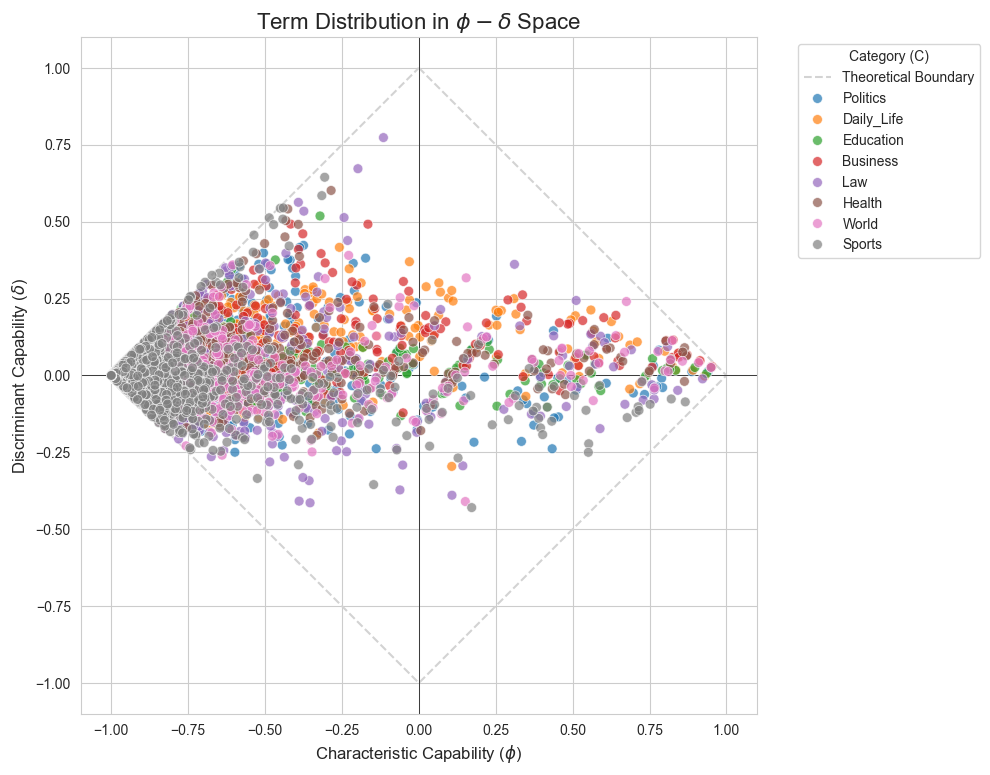

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 10))
sns.set_style("whitegrid")


rhombus_x = [0, 1, 0, -1, 0]
rhombus_y = [1, 0, -1, 0, 1]
plt.plot(rhombus_x, rhombus_y, color='lightgray', linestyle='--', zorder=1, label='Theoretical Boundary')



sns.scatterplot(
    data=results_df,
    x='phi',
    y='delta',
    hue='label',  # Color points by their target category
    alpha=0.7,
    s=50,  # Marker size
    zorder=2
)

plt.title(r'Term Distribution in $\phi-\delta$ Space', fontsize=16)
plt.xlabel(r'Characteristic Capability ($\phi$)', fontsize=12)
plt.ylabel(r'Discriminant Capability ($\delta$)', fontsize=12)


# Add center lines
plt.axhline(0, color='black', linewidth=0.5, zorder=1)
plt.axvline(0, color='black', linewidth=0.5, zorder=1)

# Ensure the plot is square
plt.gca().set_aspect('equal', adjustable='box')


plt.legend(title='Category (C)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.savefig('plot/task6_term_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [25]:




# Calculate 'stopword_score'
results_df['abs_delta'] = results_df['delta'].abs()
results_df['stopword_score'] = results_df['phi'] - results_df['abs_delta']

# Filter for potential stopwords (phi > 0)
stopwords_df = results_df[results_df['phi'] > 0]


top_5_per_label = stopwords_df.sort_values(
    by='stopword_score', ascending=False
).groupby('label').head(5).copy()


cols_to_print = ['word', 'phi', 'delta', 'stopword_score']
display_column_created = False


print("Translating top 5 stopwords (word by word)...")
unique_words = top_5_per_label['word'].unique().tolist()
translated_list = translate_words(unique_words)

translation_map = dict(zip(unique_words, translated_list))
top_5_per_label['translation (en)'] = top_5_per_label['word'].map(translation_map)





# Create a rank column (1 to 5) for each label group
top_5_per_label['rank'] = top_5_per_label.groupby('label').cumcount() + 1


print("Formatting with translations...")
top_5_per_label['display'] = top_5_per_label['word'] + " (" + top_5_per_label['translation (en)'].fillna('N/A') + ")"



side_by_side_df = top_5_per_label.pivot(
    index='rank', 
    columns='label', 
    values='display'
)

side_by_side_df = side_by_side_df.fillna('') # Replace NaN
side_by_side_df.index.name = 'Rank'

print("\n" + "="*50)
print("Top 5 Plausible Stopwords (Side-by-Side)")
print("="*50)


print(side_by_side_df.to_string())

Translating top 5 stopwords (word by word)...
Formatting with translations...

Top 5 Plausible Stopwords (Side-by-Side)
label         Business       Daily_Life        Education           Health              Law         Politics           Sports            World
Rank                                                                                                                                         
1             và (and)         và (and)         và (and)         và (and)         và (and)         và (and)         và (and)         và (and)
2      của (belong to)  của (belong to)  của (belong to)  của (belong to)  của (belong to)  của (belong to)  của (belong to)  của (belong to)
3           trong (in)       trong (in)       trong (in)       trong (in)        có (Have)        có (Have)       với (with)       trong (in)
4          được (Okay)      được (Okay)      được (Okay)      được (Okay)       cho (give)       trong (in)       trong (in)      được (Okay)
5            có (Have)      

In [26]:

import pandas as pd


term_scores_df = results_df.groupby('word')[['phi', 'abs_delta', 'stopword_score']].mean().reset_index()

# Sort to find the best stopword candidates
term_scores_df = term_scores_df[term_scores_df['phi'] > 0].sort_values(
    by='stopword_score', ascending=False
)

# Calculate precision at different K values
k_values = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
precision_results = []

for k in k_values:
    top_k_terms = term_scores_df.head(k)['word'] 
    num_matches = top_k_terms.isin(vietnamese_stopwords_set).sum()
    precision = num_matches / k
    precision_results.append({'k': k, 'precision': precision})

# create a new DataFrame for plotting
precision_df = pd.DataFrame(precision_results)

print("\nGlobal Precision Results (from vn_df):")
print(precision_df)


Global Precision Results (from vn_df):
      k  precision
0     5   1.000000
1    10   1.000000
2    20   1.000000
3    30   1.000000
4    40   1.000000
5    50   0.880000
6    60   0.733333
7    70   0.628571
8    80   0.550000
9    90   0.488889
10  100   0.440000


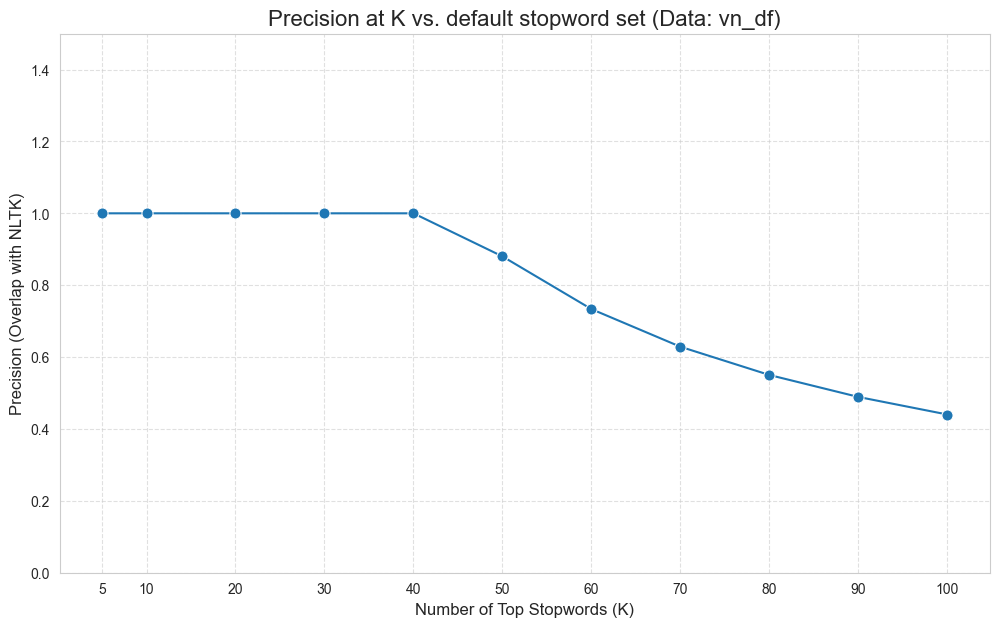

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")


sns.lineplot(
    data=precision_df,
    x='k',
    y='precision',
    marker='o',
    markersize=8
)


plt.title('Precision at K vs. default stopword set (Data: vn_df)', fontsize=16)
plt.xlabel('Number of Top Stopwords (K)', fontsize=12)
plt.ylabel('Precision (Overlap with NLTK)', fontsize=12)
plt.xticks(k_values)
plt.ylim(0, 1.5)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('plot/task6.png', dpi=300, bbox_inches='tight')


plt.show()

## Finding 

1. **Term Distribution (φ-δ Space)**

- The scatter plot visualizes all terms in our news corpus. The "ideal" stopword region, defined by **high φ** (x-axis) and **low |δ|** (y-axis), is the far-right quadrant. We observe a dense cluster of words from all categories in this targeted region, confirming that many words in the corpus fit this statistical profile.

2. **High Per-Category Consistency**

- When we identified the top 5 candidates within each category using this method, the results were remarkably consistent: `và (and)` and `của (of)` were ranked as the top 2 stopwords in all 8 categories.The top 5 lists are dominated by the same set of common function words (like `trong, được, có`), proving they behave as ideal stopwords in every topic.

3. **Precision vs. NLTK List**

- We then created a single, globally-ranked list and compared it to the default NLTK stopword list, as required by the "nested evaluation"

- The results show 100% precision for the top 40 words (K=40). This is a **strong validation**: the 40 words that best fit the Armano criteria in our corpus are all present in the standard NLTK list. 

- After K=40, precision declines (e.g., 44% at K=100). This indicates our method then begins to identify words that are statistically "stopword-like" in this specific news corpus but are not considered general-purpose stopwords.

## Conclusion

- The **Armano et al.** method was **highly effective** in our Vietnamese news corpus. It successfully and consistently identified core function words (`và, của`) as the top candidates by demonstrating they have high spread (φ) and low distinctiveness (δ) across all topics. The 100% precision for the top 40 words confirms this statistical approach strongly aligns with the established NLTK stopword list.

# Question 7: 2D Representation

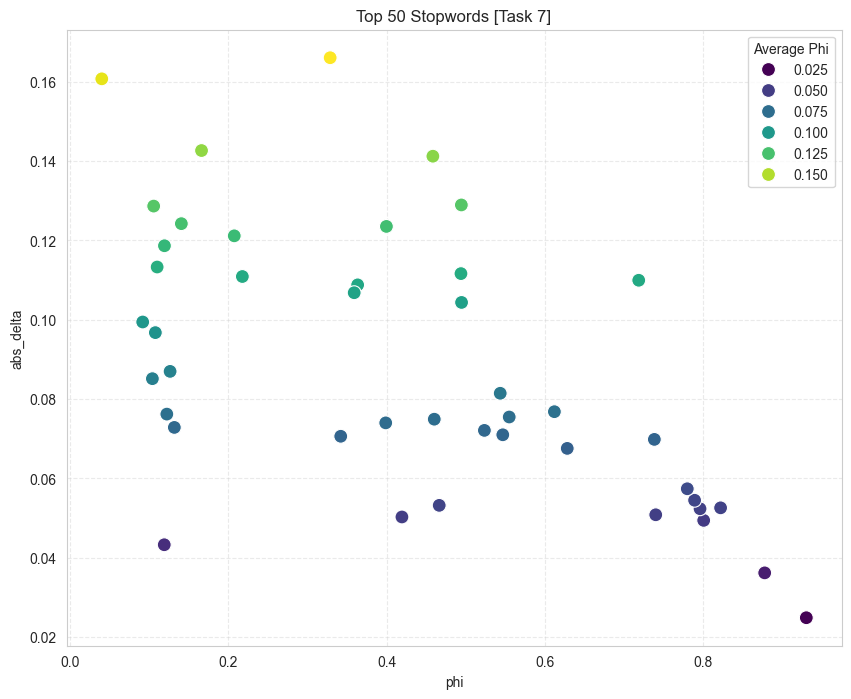

In [28]:
# Select top 50 stopwords based on 6
# loading from pkl file would require another sort

top50_df = term_scores_df.head(50).copy()

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='phi', 
    y='abs_delta', 
    data=top50_df, 
    hue='abs_delta', 
    palette='viridis', 
    s=100
)

plt.title("Top 50 Stopwords [Task 7]")
plt.xlabel("phi")
plt.ylabel("abs_delta")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(title="Average Phi", loc='upper right')

plt.savefig('plot/task7.png', dpi=300, bbox_inches='tight')
plt.show()


## Findings

- **Target Region**: The ideal stopword candidates, according to the **Armano et al.** criteria, are those with `high φ` and `low |δ|`. This corresponds to the bottom-right corner of the plot.

- **Cluster Confirmation**: The plot clearly shows a dense cluster of points exactly in this target region (roughly `φ > 0.7` and `|δ| < 0.08`). This visually confirms that the top words identified by the Armano method (which we found in Task 6 to be common function words like `và, của,...`) fit the statistical profile of an ideal stopword perfectly.

- **Outliers**: The few points scattered to the top-left (e.g., `low φ`, `high |δ|`) represent words that are less ideal—they are either less evenly spread or more distinctive than the main group. These are likely the words that appeared just outside the Top 40 in our Task 6 precision list.

## Conclusion

This plot provides the statistical map of our best stopword candidates. It forms the basis for Task 8, where we will apply K-Means clustering to this exact data, and for Task 10, where we will compare these statistical groupings to semantic groupings.

# Question 8: K-mean algorithm

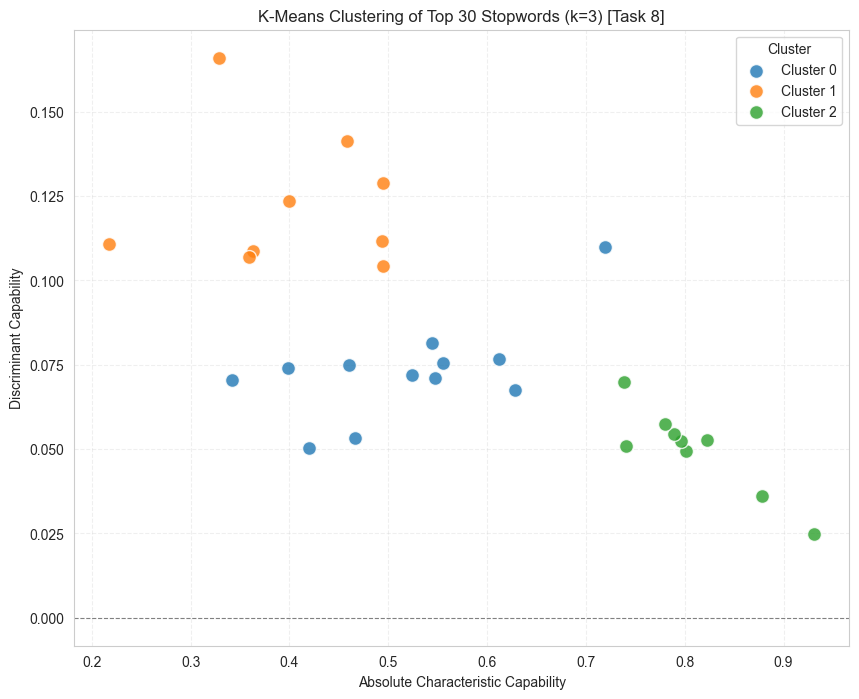

In [29]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

TOP_N_CLUSTER = 30
NUM_CLUSTERS = 3  


# Select top 30 stopwords from 6 
top30_cluster_df = term_scores_df.head(TOP_N_CLUSTER).copy()

# Features for clustering
X = top30_cluster_df[['abs_delta', 'phi']].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10)
top30_cluster_df['cluster'] = kmeans.fit_predict(X_scaled)


# plot
plt.figure(figsize=(10, 8))
for cluster_id in sorted(top30_cluster_df['cluster'].unique()):
    subset = top30_cluster_df[top30_cluster_df['cluster'] == cluster_id]
    plt.scatter(
        subset['phi'],
        subset['abs_delta'],
        s=100,
        label=f"Cluster {cluster_id}",
        alpha=0.8,
        edgecolors='w'
    )


plt.title(f"K-Means Clustering of Top {TOP_N_CLUSTER} Stopwords (k={NUM_CLUSTERS}) [Task 8]")
plt.xlabel("Absolute Characteristic Capability")
plt.ylabel("Discriminant Capability")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title="Cluster")

plt.savefig('plot/task8.png', dpi=300, bbox_inches='tight')
plt.show()



In [30]:

print("\n Cluster Summary (Top 30 Stopwords by Cluster with Translation) [Task 8]")

cluster_ids = sorted(top30_cluster_df['cluster'].unique())

# Loop through each cluster
for cluster_id in cluster_ids:
    print(f"\nCluster {cluster_id}:")
    subset_df = top30_cluster_df[top30_cluster_df['cluster'] == cluster_id].copy() 

    subset_df['translation'] = translate_words(subset_df['word'].tolist())
    print(subset_df[['word', 'translation', 'abs_delta', 'phi', 'cluster']].to_markdown(index=False, floatfmt=".4f"))



 Cluster Summary (Top 30 Stopwords by Cluster with Translation) [Task 8]

Cluster 0:
| word   | translation   |   abs_delta |    phi |   cluster |
|:-------|:--------------|------------:|-------:|----------:|
| các    | the           |      0.1099 | 0.7189 |         0 |
| để     | to            |      0.0676 | 0.6285 |         0 |
| khi    | When          |      0.0768 | 0.6122 |         0 |
| không  | Are not       |      0.0755 | 0.5551 |         0 |
| đó     | there         |      0.0710 | 0.5470 |         0 |
| này    | This          |      0.0815 | 0.5437 |         0 |
| về     | about         |      0.0721 | 0.5238 |         0 |
| vào    | enter         |      0.0532 | 0.4666 |         0 |
| từ     | from          |      0.0749 | 0.4604 |         0 |
| ra     | go out        |      0.0503 | 0.4195 |         0 |
| trên   | above         |      0.0740 | 0.3990 |         0 |
| sau    | after         |      0.0706 | 0.3421 |         0 |

Cluster 1:
| word   | translation   |   abs_d

## Analysis
The K-Means algorithm successfully partitioned the words into three distinct groups based on their statistical profiles:

1. **Cluster 2 (Green)**:

    Statistical Similarity: This cluster (bottom-right) represents the "Ideal Stopwords". Its members have the highest Characteristic Capability (φ) (avg. > 0.8) and the lowest Discriminant Capability (|δ|) (avg. < 0.06).

    Word Similarity: These are the most common, high-frequency "glue" words in the language, including `và (and), của (of), là (to be)`, and `có (have)`. They perfectly match the Armano criteria of being highly spread and non-distinctive .

2. **Cluster 0 (Blue)**:

    Statistical Similarity: This is the "Intermediate" group. Its members have moderate φ scores (approx. 0.35–0.7) and low-to-moderate |δ| scores.

    Word Similarity: This cluster contains common function words that are slightly more specific than Cluster 2. It includes prepositions of time/place (`khi, vào, từ, trên, sau, ra`), negation (not) (`không`), and demonstratives (`này, đó`).

3. **Cluster 1 (Orange)**:

    Statistical Similarity: This cluster represents the "Most Discriminative" (or least "stopword-like") words within this Top 30 group. Its members have the highest Discriminant Capability (|δ|) (avg. > 0.1) and generally lower Characteristic Capability (φ).

    Word Similarity: This group contains words that, while common, carry more specific semantic weight, such as `người (people), một (one), nhiều (much)`, and the future-tense verb `sẽ (will)`. Their higher |δ| scores suggest they are not as evenly distributed as the words in Cluster 2.

# Question 9: Using default stopword set

Scaling features and running K-Means...
Clustering complete.
Plotting clusters for Task 9...


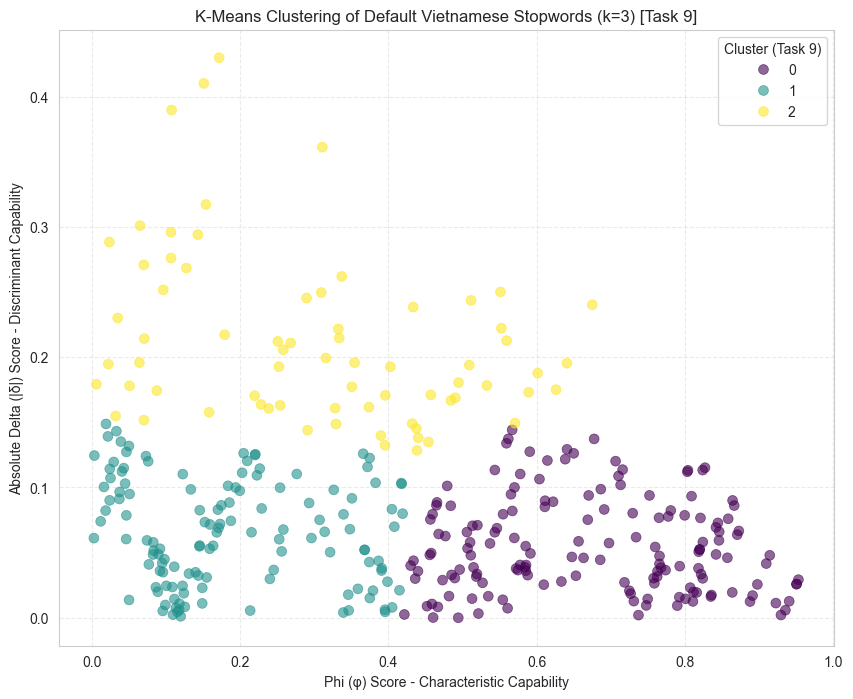

In [31]:

ranked_words_df = stopwords_df

# Get default stopwords present in corpus

corpus_words_set = set(ranked_words_df['word'])
default_stopwords_in_corpus = [word for word in vietnamese_stopwords_set if word in corpus_words_set]

if len(default_stopwords_in_corpus) == 0:
    raise ValueError("No default Vietnamese stopwords were found in the corpus results from Task 6.")


# Filter ranked_words_df to get only the rows for default stopwords
default_stopwords_cluster_df = ranked_words_df[ranked_words_df['word'].isin(default_stopwords_in_corpus)].copy()


print("Scaling features and running K-Means...")
# Select features for clustering
X_default = default_stopwords_cluster_df[['phi', 'abs_delta']].values

# Scale features
scaler_default = StandardScaler() # Assumes StandardScaler is imported
X_default_scaled = scaler_default.fit_transform(X_default)
# Apply K-Means
kmeans_default = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10) 
default_stopwords_cluster_df['cluster'] = kmeans_default.fit_predict(X_default_scaled)
print("Clustering complete.")


print("Plotting clusters for Task 9...")
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=default_stopwords_cluster_df,
    x='phi', 
    y='abs_delta', 
    hue='cluster',
    palette='viridis', 
    s=50, alpha=0.6, edgecolor=None 
)

plt.title(f"K-Means Clustering of Default Vietnamese Stopwords (k={NUM_CLUSTERS}) [Task 9]")
plt.xlabel("Phi (φ) Score - Characteristic Capability") 
plt.ylabel("Absolute Delta (|δ|) Score - Discriminant Capability") 
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(title="Cluster (Task 9)")
plt.savefig(os.path.join('plot','task9.png'), dpi=300, bbox_inches='tight') 
plt.show()



In [32]:


print("\n Cluster Summary (Default Stopwords by Cluster with Translation) [Task 9] ")
cluster_ids_task9 = sorted(default_stopwords_cluster_df['cluster'].unique())
    
# Loop through each cluster
for cluster_id in cluster_ids_task9:
    print(f"\nCluster {cluster_id}:")
    
    # only do 10 because there's a lot
    subset_df_task9 = default_stopwords_cluster_df[default_stopwords_cluster_df['cluster'] == cluster_id].head(10).copy() 
    subset_df_task9['translation'] = translate_words(subset_df_task9['word'].tolist())
    print(subset_df_task9[['word', 'translation', 'delta', 'phi', 'cluster']].to_markdown(index=False, floatfmt=".4f"))



 Cluster Summary (Default Stopwords by Cluster with Translation) [Task 9] 

Cluster 0:
| word   | translation   |   delta |    phi |   cluster |
|:-------|:--------------|--------:|-------:|----------:|
| cho    | give          | -0.0619 | 0.7339 |         0 |
| các    | the           |  0.0824 | 0.7806 |         0 |
| có     | Have          | -0.0094 | 0.7894 |         0 |
| của    | belong to     |  0.0125 | 0.8875 |         0 |
| là     | To be         | -0.0357 | 0.7627 |         0 |
| theo   | according to  | -0.0166 | 0.4816 |         0 |
| trong  | in            | -0.0396 | 0.7926 |         0 |
| và     | and           |  0.0127 | 0.9403 |         0 |
| về     | about         |  0.1207 | 0.6143 |         0 |
| với    | with          | -0.0574 | 0.6974 |         0 |

Cluster 1:
| word   | translation   |   delta |    phi |   cluster |
|:-------|:--------------|--------:|-------:|----------:|
| biết   | know          | -0.1196 | 0.0296 |         1 |
| còn    | still         | -0.

## Analysis of Cluster Similarities
The algorithm successfully partitioned the default stopwords into three distinct statistical profiles:

1. **Cluster 0 (Purple): "Ideal" Stopwords**

    Statistical Profile: This group is clustered in the bottom-right corner. It represents words with High Characteristic Capability (φ) (they are spread evenly across all 8 categories) and Low Discriminant Capability (|δ|) (they do not distinguish any category) .

    Word Similarity: The tables confirm this cluster contains the most ubiquitous function words, such as `và (and), của (of), là (to be), and có (have)`. These are the "best" stopwords in our corpus according to the Armano et al. criteria.

2. **Cluster 1 (Teal): "Intermediate" or "Less Frequent" Stopwords**

    Statistical Profile: This group occupies the middle-left. It contains words with Low-to-Mid φ scores (not as evenly spread) but still relatively Low |δ| scores (not very discriminative).

    Word Similarity: This cluster includes common words like `biết (know), hơn (than), and ngày (day)`. These are legitimate stopwords, but they likely appear less frequently or less evenly in our news data than the "ideal" words in Cluster 0.

3. **Cluster 2 (Yellow): "Discriminative" Stopwords**

    Statistical Profile: This group is in the upper-left/center. It represents words with High Discriminant Capability (|δ|) and/or Low Characteristic Capability (φ).

    Word Similarity: These are NLTK stopwords that are not behaving like stopwords in this dataset. Words like `người (people), một (one), and không (not)`, while common, are likely used more in certain news topics than others, making them statistically "distinctive" (high |δ|).

# Question 10: W2V model

Loading cached Task 10 results from pkl_folder\task10_top30_armano.pkl...
Results loaded.


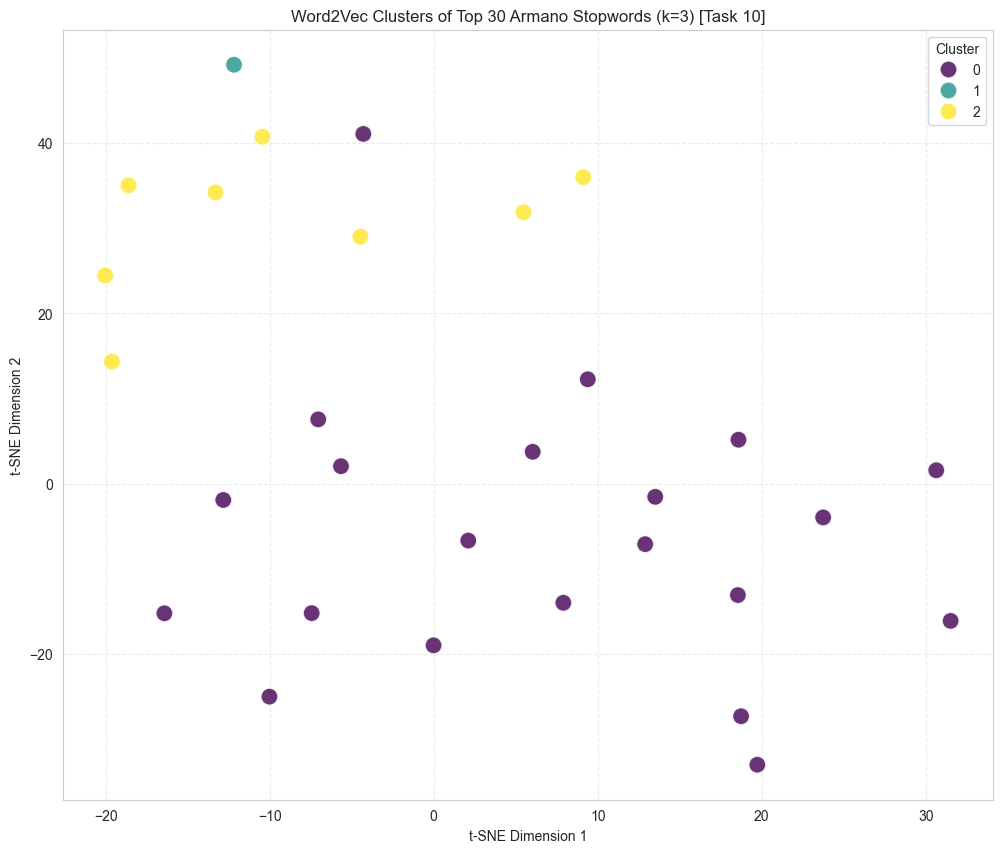

In [33]:
TASK10_TOP30_PKL = os.path.join(PKL_FOLDER, 'task10_top30_armano.pkl') 
NUM_CLUSTERS = 3 

if os.path.exists(TASK10_TOP30_PKL):
    print(f"Loading cached Task 10 results from {TASK10_TOP30_PKL}...")
    with open(TASK10_TOP30_PKL, 'rb') as f:
        cluster_summary = pickle.load(f)
        X_tsne = pickle.load(f)
    print("Results loaded.")

else:
    top_terms = top30_cluster_df['word'].tolist()

    X_w2v = []
    valid_terms = []

    print("Extracting Word2Vec embeddings for Top 30 Armano stopwords...")
    for term in tqdm(top_terms, desc="Embedding extraction (Top 30)"):
        if term in w2v_model:       
            X_w2v.append(w2v_model[term])
            valid_terms.append(term)

    X_w2v = np.array(X_w2v)
    print(f"Found embeddings for {len(valid_terms)} / {len(top_terms)} words.")

    if len(valid_terms) == 0:
        raise ValueError("No embeddings found for the top 30 words. Cannot proceed.")

    # Cluster on embeddings
    print(f"Running K-Means clustering on embeddings (k={NUM_CLUSTERS})...")
    kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=12, n_init=10)
    clusters = kmeans.fit_predict(X_w2v)
    print("Clustering completed.")


    print("Running t-SNE for visualization...")
    perplexity_val_top30 = min(5, len(valid_terms) - 1)
    if perplexity_val_top30 < 1:
        perplexity_val_top30 = 1

    tsne = TSNE(
        n_components=2,
        random_state=1,
        perplexity=perplexity_val_top30,
        init='pca'
    )
    X_tsne = tsne.fit_transform(X_w2v)
    print("t-SNE completed.")

    # Combine results
    cluster_summary = pd.DataFrame({
        "word": valid_terms,
        "tsne_1": X_tsne[:, 0],
        "tsne_2": X_tsne[:, 1],
        "cluster": clusters
    })

    # Save results
    print(f"Saving Task 10 (Top 30) results to {TASK10_TOP30_PKL}...")
    with open(TASK10_TOP30_PKL, 'wb') as f:
        pickle.dump(cluster_summary, f)
        pickle.dump(X_tsne, f)
    print("Results saved.")

# plot
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=cluster_summary,
    x='tsne_1',
    y='tsne_2',
    hue='cluster',
    palette='viridis',
    s=150, alpha=0.8, edgecolor='w'
)


plt.title(f"Word2Vec Clusters of Top 30 Armano Stopwords (k={NUM_CLUSTERS}) [Task 10]")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster")
plt.grid(True, linestyle='--', alpha=0.4)
plt.savefig('plot/task10_top30_armano.png', dpi=300, bbox_inches='tight')
plt.show()


Loading cached Task 10 (Default) results from pkl_folder\task10_default.pkl...
Results loaded.


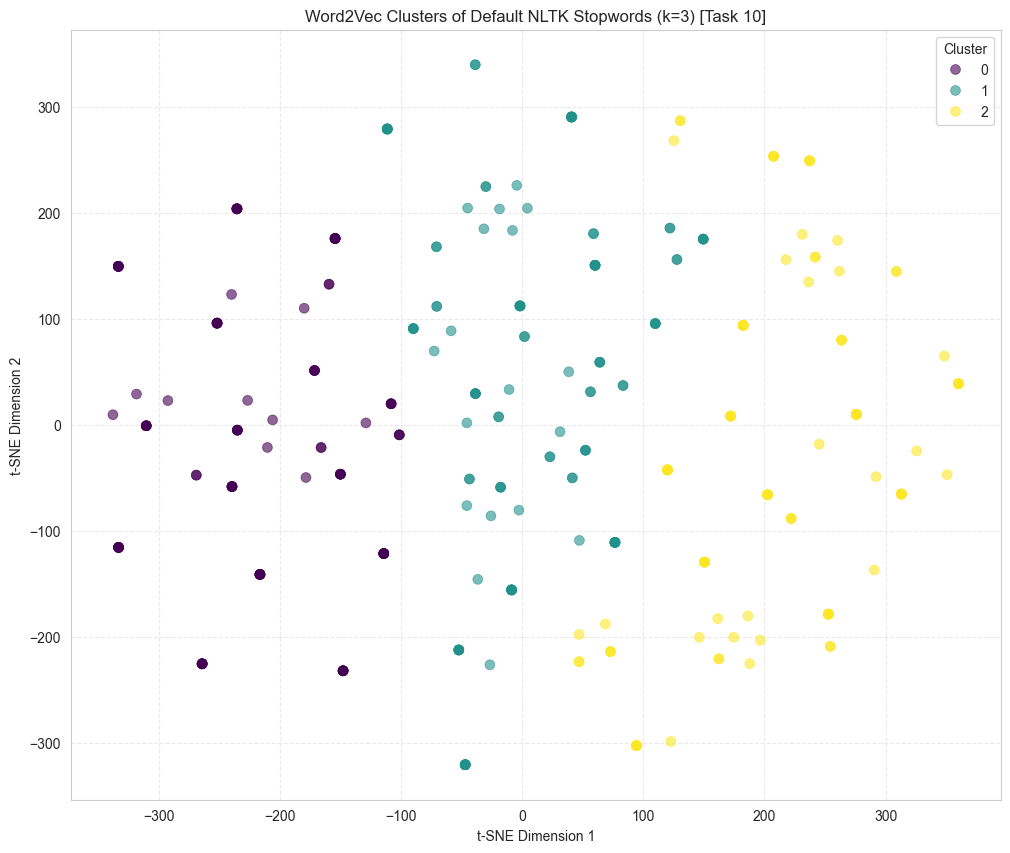

In [34]:
TASK10_DEFAULT_PKL = os.path.join(PKL_FOLDER, 'task10_default.pkl') 

if os.path.exists(TASK10_DEFAULT_PKL):
    print(f"Loading cached Task 10 (Default) results from {TASK10_DEFAULT_PKL}...")
    with open(TASK10_DEFAULT_PKL, 'rb') as f:
        cluster_summary_default = pickle.load(f)
        X_tsne_default = pickle.load(f)
    print("Results loaded.")

else:
    print("Cache not found for Task 10 (Default). Running analysis...")
    
    default_terms = default_stopwords_cluster_df['word'].tolist() 

    X_w2v_default = []      
    valid_terms_default = [] 

    print("Extracting Word2Vec embeddings for default stopwords (present in corpus)...")
    for term in tqdm(default_terms, desc="Embedding extraction (Default)"):
        if term in w2v_model:  
            X_w2v_default.append(w2v_model[term])
            valid_terms_default.append(term)

    X_w2v_default = np.array(X_w2v_default)
    print(f"Found embeddings for {len(valid_terms_default)} / {len(default_terms)} words.")

    if len(valid_terms_default) == 0:
         raise ValueError("No embeddings found for the default stopwords. Cannot proceed.")

    # Cluster on embeddings
    print(f"Running K-Means clustering on embeddings (k={NUM_CLUSTERS}) for default stopwords...")
    kmeans_default = KMeans(n_clusters=NUM_CLUSTERS, random_state=1, n_init=10)
    clusters_default = kmeans_default.fit_predict(X_w2v_default)
    print("Clustering completed.")

    print("Running t-SNE for visualization...")
    perplexity_val = min(30, len(valid_terms_default) - 1)
    if perplexity_val < 1:
        perplexity_val = 1

    tsne_default = TSNE(
        n_components=2,
        random_state=1,
        perplexity=perplexity_val,
        init='pca'
    )
    X_tsne_default = tsne_default.fit_transform(X_w2v_default)
    print("t-SNE completed.")

    cluster_summary_default = pd.DataFrame({
        "word": valid_terms_default,
        "tsne_1": X_tsne_default[:, 0],
        "tsne_2": X_tsne_default[:, 1],
        "cluster": clusters_default
    })


    print(f"Saving Task 10 (Default) results to {TASK10_DEFAULT_PKL}...")
    with open(TASK10_DEFAULT_PKL, 'wb') as f:
        pickle.dump(cluster_summary_default, f)
        pickle.dump(X_tsne_default, f)
    print("Results saved.")


plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=cluster_summary_default,
    x='tsne_1',
    y='tsne_2',
    hue='cluster',
    palette='viridis', 
    s=50, alpha=0.6, edgecolor=None
)

plt.title(f"Word2Vec Clusters of Default NLTK Stopwords (k={NUM_CLUSTERS}) [Task 10]")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster")
plt.grid(True, linestyle='--', alpha=0.4)
plt.savefig(os.path.join('plot','task10_default.png'), dpi=300, bbox_inches='tight')
plt.show()


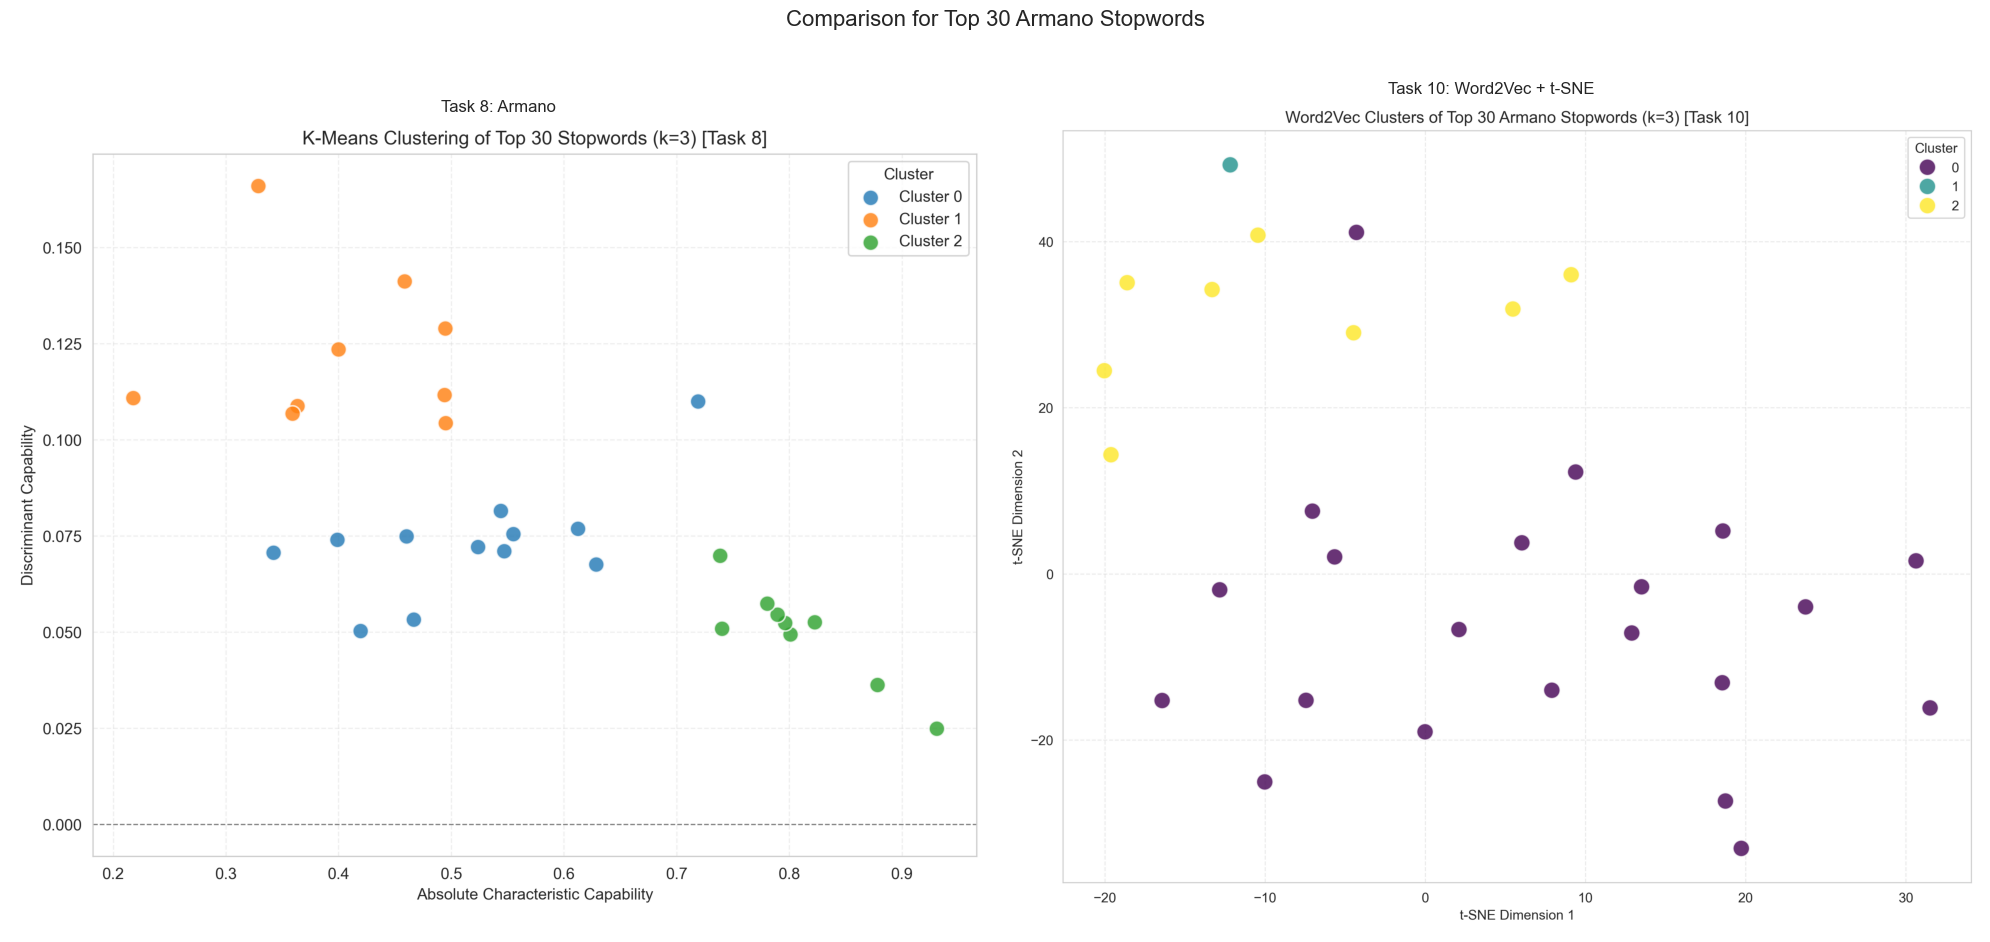

In [35]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os


# Comparison for Top 30 Armano Stopwords 


task8_img_path = 'plot/task8.png'
task10_top30_img_path = 'plot/task10_top30_armano.png'

task9_img_path = os.path.join('plot/task9.png')
task10_default_img_path = os.path.join('plot/task10_default.png')

fig1, axes1 = plt.subplots(1, 2, figsize=(20, 10))
img8 = mpimg.imread(task8_img_path)
axes1[0].imshow(img8)
axes1[0].set_title('Task 8: Armano')
axes1[0].axis('off') 
img10_top30 = mpimg.imread(task10_top30_img_path)
axes1[1].imshow(img10_top30)
axes1[1].set_title('Task 10: Word2Vec + t-SNE')
axes1[1].axis('off')

fig1.suptitle('Comparison for Top 30 Armano Stopwords', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()




In [36]:
print("Creating merged DataFrame with cluster assignments...")


task8_clusters_to_merge = top30_cluster_df[['word', 'cluster']].rename(
    columns={'cluster': 'cluster_task8'}
)
task10_clusters_to_merge = cluster_summary[['word', 'cluster']].rename(
    columns={'cluster': 'cluster_task10'}
)

# Use outer merge in case some words were missing embeddings in Task 10
merged_clusters = pd.merge(
    task8_clusters_to_merge,
    task10_clusters_to_merge,
    on='word',
    how='outer' # Keep all words from both analyses
)

merged_clusters['Translation'] = translate_words(merged_clusters['word'].tolist())
display_cols = ['word', 'Translation', 'cluster_task8', 'cluster_task10']

print("\n==== Merged Cluster Assignments (Task 8 vs Task 10) ====")
print("      (Top 30 Armano Stopwords)")
print(merged_clusters[display_cols].sort_values(by=['cluster_task8', 'cluster_task10']).to_markdown(index=False, floatfmt=".0f"))


Creating merged DataFrame with cluster assignments...

==== Merged Cluster Assignments (Task 8 vs Task 10) ====
      (Top 30 Armano Stopwords)
| word   | Translation   |   cluster_task8 |   cluster_task10 |
|:-------|:--------------|----------------:|-----------------:|
| các    | the           |               0 |                0 |
| không  | Are not       |               0 |                0 |
| này    | This          |               0 |                0 |
| trên   | above         |               0 |                0 |
| về     | about         |               0 |                0 |
| đó     | there         |               0 |                0 |
| để     | to            |               0 |                0 |
| khi    | When          |               0 |                2 |
| ra     | go out        |               0 |                2 |
| sau    | after         |               0 |                2 |
| từ     | from          |               0 |                2 |
| vào    | enter        

## Findings top 30 armano:


**Significant Divergence:** There is very little direct correspondence between the clusters formed in Task 8 and Task 10. Words grouped together based on similar statistical distribution are often placed in different clusters based on semantic similarity (Word2Vec/t-SNE), and vice-versa.
   
1.  **Task 8 Clustering (Armano):**
    - **Cluster 2 (Green)**: Contains the "ideal" stopwords with the highest φ (spread) and lowest |δ| (distinctiveness). As the table shows, this includes core function words like và (and), của (of), là (to be), and có (have).

    - **Cluster 1 (Orange)**: Contains words with the highest |δ| scores, making them the most "discriminative" or least stopword-like in this group (e.g., người - people, một - one).

    - **Cluster 0 (Blue)**: Contains intermediate words.
  
2.  **Task 10 Clustering (Word2Vec/t-SNE):**
    - **Cluster 0 (Purple)**: This is a large, general-purpose cluster. It groups most of the "ideal" stopwords from Task 8, Cluster 2 (like `và, của, là`) plus many words from Task 8, Cluster 1 (like `cũng, một, những`). This suggests Word2Vec sees them all as common, general function words.

    - **Cluster 2 (Yellow)**: This cluster appears to group words related to time, place, or direction, such as `khi (when), sau (after), từ (from), vào (in), đến (to/arrive), and đã (already)`.

    - **Cluster 1 (Teal)**: This cluster isolates `người (people)`, indicating its meaning is very distinct from the other 29 words.
  

**Interpretation:**

* Clustering based on **corpus-specific statistical distribution (Task 8)** doesn't align well with clustering based on **general semantic context (Task 10)** for this set of words.

* Task 8 primarily separates words based on how evenly they are spread across *specific news categories*.
  
* Task 10 primarily separates words based on their learned meaning and grammatical function from a large, general text corpus (used to train Word2Vec).

  
* This means words that behave similarly statistically within this specific dataset (e.g., being equally spread out or rare) **don't necessarily have similar meanings or grammatical functions** according to the broader language context learned by Word2Vec. 

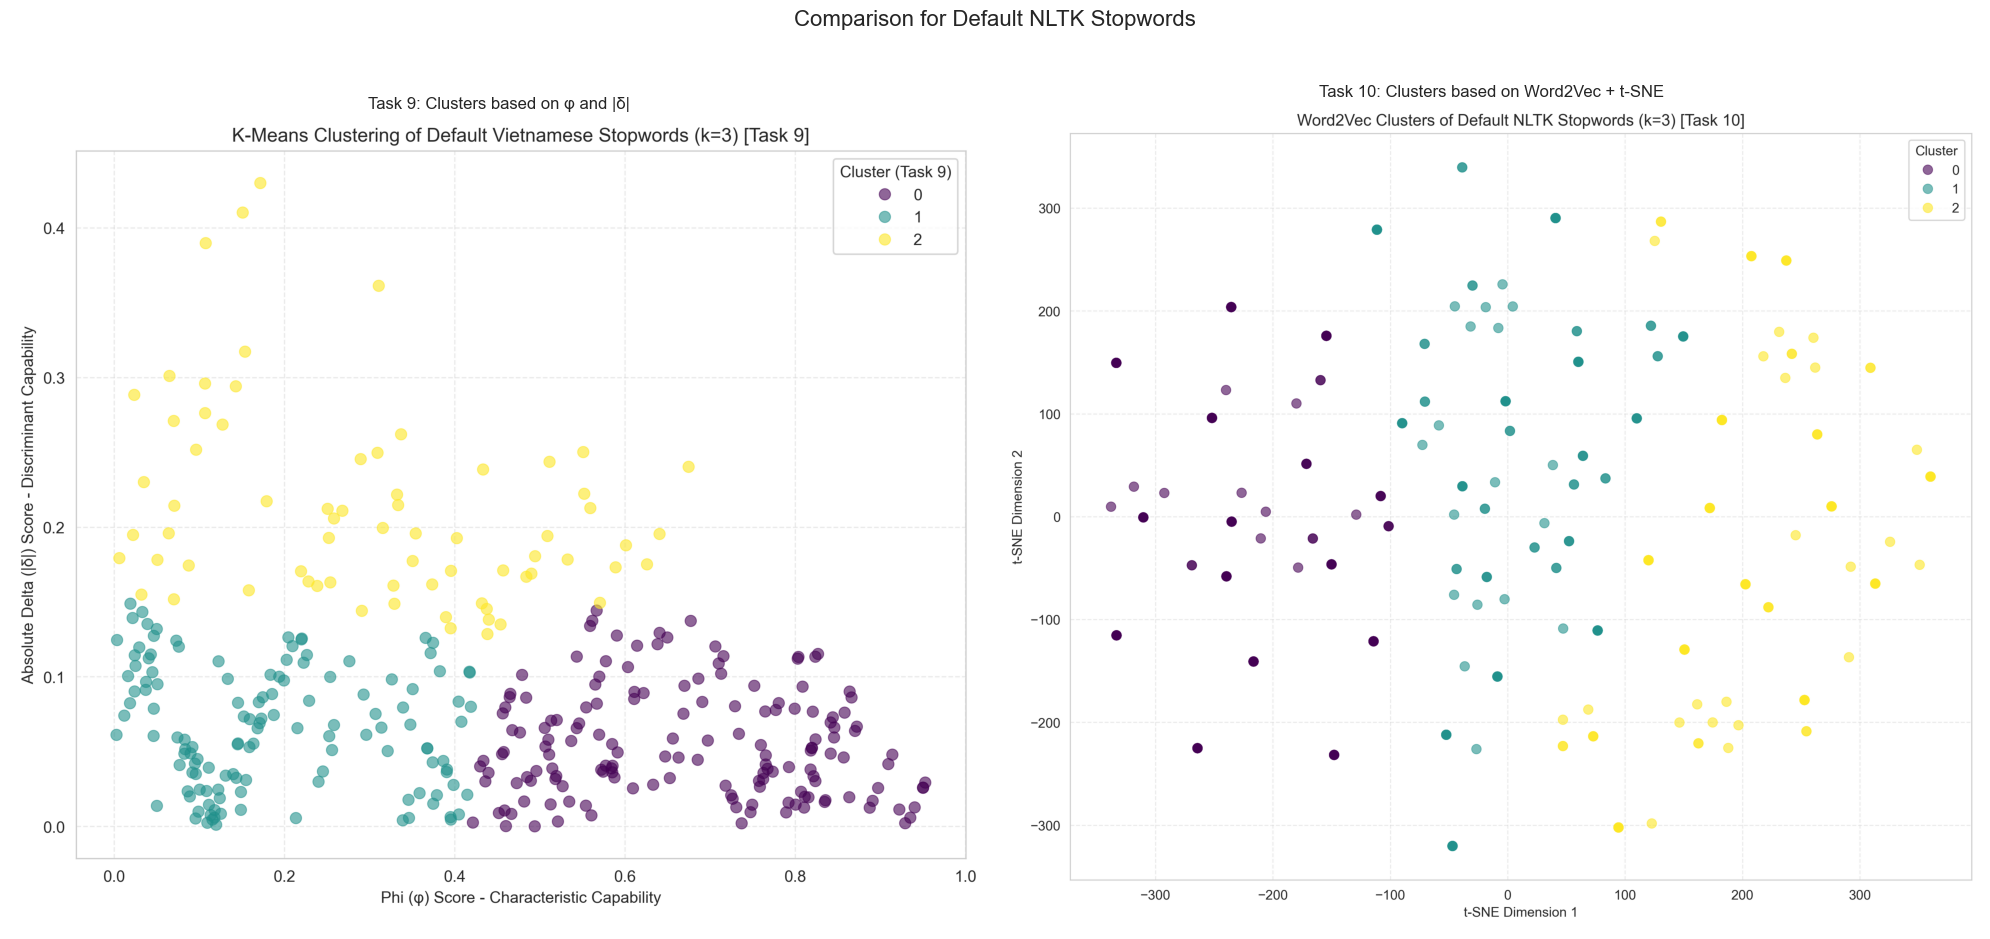

In [37]:

# Comparison for Default NLTK Stopwords 
fig2, axes2 = plt.subplots(1, 2, figsize=(20, 10))

img9 = mpimg.imread(task9_img_path)
axes2[0].imshow(img9)
axes2[0].set_title('Task 9: Clusters based on φ and |δ|')
axes2[0].axis('off')

img10_default = mpimg.imread(task10_default_img_path)
axes2[1].imshow(img10_default)
axes2[1].set_title('Task 10: Clusters based on Word2Vec + t-SNE')
axes2[1].axis('off')
fig2.suptitle('Comparison for Default NLTK Stopwords', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [38]:


print("Merging Task 9 and Task 10 cluster assignments for common words...")


task9_data_full = default_stopwords_cluster_df[['word', 'cluster']].rename(
    columns={'cluster': 'cluster_task9'}
)
task10_data_full = cluster_summary_default[['word', 'cluster']].rename(
    columns={'cluster': 'cluster_task10'}
)

# use "inner" because there are a lot 
merged_common_words = pd.merge(
    task9_data_full,
    task10_data_full,
    on='word',
    how='inner' # Keep only words that appear in both dataframes
)

# Check if enough common words exist
num_common = len(merged_common_words)
sample_size = min(30, num_common) # Take 30 or fewer if less than 30 common words

if num_common < 30:
    print(f"Warning: Only {num_common} words were found in both Task 9 and Task 10 results. Sampling {num_common} words.")
else:
    print(f"Found {num_common} common words. Sampling 30...")


merged_clusters_sample = merged_common_words.sample(n=sample_size, random_state=2)


print("Adding translations...")
merged_clusters_sample['Translation'] = translate_words(merged_clusters_sample['word'].tolist())
display_cols = ['word', 'Translation', 'cluster_task9', 'cluster_task10']




print(f"\n--- Random Sample of {sample_size} Common Words: Cluster Assignments (Task 9 vs Task 10) ---")
# Sort for potentially clearer viewing
print(merged_clusters_sample[display_cols].sort_values(by=['cluster_task9', 'cluster_task10']).to_markdown(index=False, floatfmt=".0f"))

Merging Task 9 and Task 10 cluster assignments for common words...
Found 2647 common words. Sampling 30...
Adding translations...

--- Random Sample of 30 Common Words: Cluster Assignments (Task 9 vs Task 10) ---
| word   | Translation   |   cluster_task9 |   cluster_task10 |
|:-------|:--------------|----------------:|-----------------:|
| từ     | from          |               0 |                0 |
| đó     | there         |               0 |                0 |
| người  | People        |               0 |                0 |
| ra     | go out        |               0 |                0 |
| theo   | according to  |               0 |                1 |
| có     | Have          |               0 |                1 |
| các    | the           |               0 |                1 |
| có     | Have          |               0 |                1 |
| của    | belong to     |               0 |                1 |
| trong  | in            |               0 |                1 |
| với    | with    

## Findings default list

**Divergence in Groupings:** As seen with the Armano words, the clustering results differ significantly between the two methods. A word's cluster assignment based on its statistical distribution (Task 9) often does not match its cluster based on semantic similarity (Task 10).

1.  **Task 9 Clusters (φ/δ):**
    - **Cluster 0**: Contains words that best fit the Armano criteria (high φ, low |δ|) , such as của (of), là (to be), and với (with).

    - **Cluster 1 & 2**: Contain other NLTK stopwords that, in this dataset, behave less ideally (e.g., they are more discriminative or less evenly spread), such as ngày (day) or việc (job).
  

3.  **Task 10 Clusters (Word2Vec/t-SNE):**
    - **Cluster 1** (e.g., `theo, có, các, của, trong, với, là, trên`): Appears to group core prepositions, articles, and high-frequency function words.

    - **Cluster 0** (e.g., `từ, đó, người, ra, ngày, năm`): Seems to group words related to time, place, and entities.

    - **Cluster 2** (e.g., `những, việc, sẽ, nhưng, đang, cũng`): Seems to group determiners, conjunctions, and modal/auxiliary verbs.
  
  
**Semantic Coherence (Task 10):** While harder to judge from just a sample, the Task 10 clusters (right plot) likely group words with related grammatical functions or meanings (e.g., perhaps Cluster 2 contains more conjunctions/prepositions, while others contain pronouns/adverbs), whereas Task 9 groups them purely by their statistical footprint in *specific news dataset*.

**Interpretation:**

Clustering by statistical features (Task 9) reveals **how words function relative to the 8 news topics**. Clustering by semantic features (Task 10) reveals their **general linguistic role**. The mismatch proves that these two properties are not the same.

# Question 11: FastText & PhoBERT (Alternative for Glove)

Loading cached Task 11 (Top 30) results from pkl_folder\task11_ft_top30.pkl...
Results loaded.


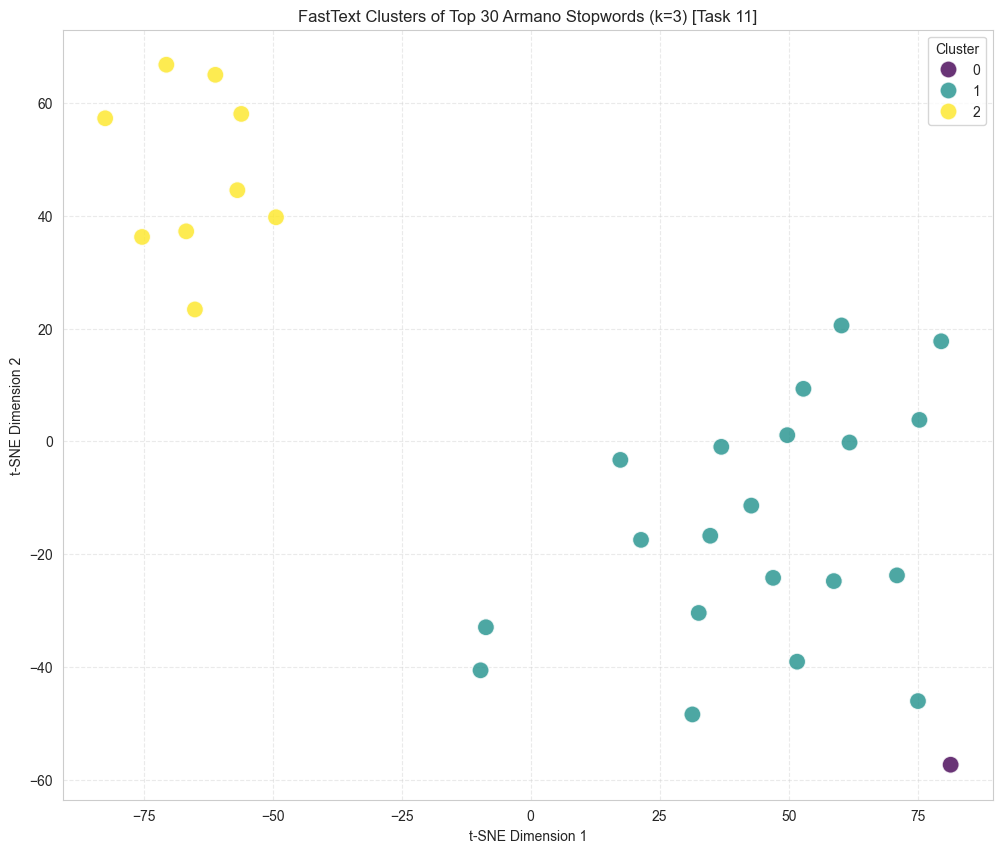

In [39]:

NUM_CLUSTERS = 3

TASK11_TOP30_PKL = os.path.join(PKL_FOLDER, 'task11_ft_top30.pkl')

if os.path.exists(TASK11_TOP30_PKL):
    print(f"Loading cached Task 11 (Top 30) results from {TASK11_TOP30_PKL}...")
    with open(TASK11_TOP30_PKL, 'rb') as f:
        cluster_summary_ft_top30 = pickle.load(f)
        X_tsne_ft_top30 = pickle.load(f)
    print("Results loaded.")

else:
    print("Cache not found for Task 11 (Top 30). Running analysis...")

    top_terms = top30_cluster_df['word'].tolist()

    X_ft_top30 = []
    valid_terms_ft_top30 = []

    print("Extracting FastText embeddings for Top 30 Armano stopwords...")
    for term in tqdm(top_terms, desc="Embedding extraction (FastText, Top 30)"):
        if term in model_ft:
            X_ft_top30.append(model_ft[term])
            valid_terms_ft_top30.append(term)

    X_ft_top30 = np.array(X_ft_top30)
    print(f"Found embeddings for {len(valid_terms_ft_top30)} / {len(top_terms)} words.")
    if len(valid_terms_ft_top30) == 0:
        raise ValueError("No embeddings found for Top 30 stopwords.")

    # Cluster on embeddings
    print(f"Running K-Means clustering (k={NUM_CLUSTERS}) on FastText embeddings...")
    kmeans_ft_top30 = KMeans(n_clusters=NUM_CLUSTERS, random_state=23, n_init=10)
    clusters_ft_top30 = kmeans_ft_top30.fit_predict(X_ft_top30)
    print("Clustering completed.")


    print("Running t-SNE...")
    perplexity_val = min(5, len(valid_terms_ft_top30) - 1)
    if perplexity_val < 1: perplexity_val = 1

    tsne_ft_top30 = TSNE(
        n_components=2,
        random_state=1,
        perplexity=perplexity_val,
        init='pca'
    )
    X_tsne_ft_top30 = tsne_ft_top30.fit_transform(X_ft_top30)
    print("t-SNE completed.")

    cluster_summary_ft_top30 = pd.DataFrame({
        "word": valid_terms_ft_top30,
        "tsne_1": X_tsne_ft_top30[:, 0],
        "tsne_2": X_tsne_ft_top30[:, 1],
        "cluster": clusters_ft_top30
    })

    print(f"Saving Task 11 (Top 30) results to {TASK11_TOP30_PKL}...")
    with open(TASK11_TOP30_PKL, 'wb') as f:
        pickle.dump(cluster_summary_ft_top30, f)
        pickle.dump(X_tsne_ft_top30, f)
    print("Results saved.")

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=cluster_summary_ft_top30,
    x='tsne_1',
    y='tsne_2',
    hue='cluster',
    palette='viridis',
    s=150, alpha=0.8, edgecolor='w'
)


plt.title(f"FastText Clusters of Top 30 Armano Stopwords (k={NUM_CLUSTERS}) [Task 11]")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster")
plt.grid(True, linestyle='--', alpha=0.4)
plt.savefig(os.path.join('plot','task11_fastText_top30.png'), dpi=300, bbox_inches='tight')
plt.show()



In [40]:
cluster_ids_t11_ft_30 = sorted(cluster_summary_ft_top30['cluster'].unique())
for cluster_id in cluster_summary_ft_top30['cluster'].unique():
        print(f"\nCluster {cluster_id}:")
        # Filter the DataFrame for the current cluster
        subset_df_t11_ft_30 = cluster_summary_ft_top30[cluster_summary_ft_top30['cluster'] == cluster_id].copy()


        # Drop duplicates by word before translating/printing
        subset_df_t11_ft_30 = subset_df_t11_ft_30.drop_duplicates(subset=['word'])


        subset_df_t11_ft_30['Translation'] = translate_words(subset_df_t11_ft_30['word'].tolist())
        # Display table including translation
        print(subset_df_t11_ft_30[['word', 'Translation', 'cluster']].to_markdown(index=False))


Cluster 2:
| word   | Translation   |   cluster |
|:-------|:--------------|----------:|
| và     | and           |         2 |
| có     | Have          |         2 |
| là     | To be         |         2 |
| đã     | Satisfied     |         2 |
| để     | to            |         2 |
| đó     | there         |         2 |
| về     | about         |         2 |
| ra     | go out        |         2 |
| sẽ     | will          |         2 |

Cluster 1:
| word   | Translation   |   cluster |
|:-------|:--------------|----------:|
| của    | belong to     |         1 |
| trong  | in            |         1 |
| được   | Okay          |         1 |
| cho    | give          |         1 |
| với    | with          |         1 |
| các    | the           |         1 |
| khi    | When          |         1 |
| không  | Are not       |         1 |
| này    | This          |         1 |
| vào    | enter         |         1 |
| người  | People        |         1 |
| theo   | according to  |         1 |
|

Loading cached Task 11 (Default) results from pkl_folder\task11_ft_default.pkl...
Results loaded.


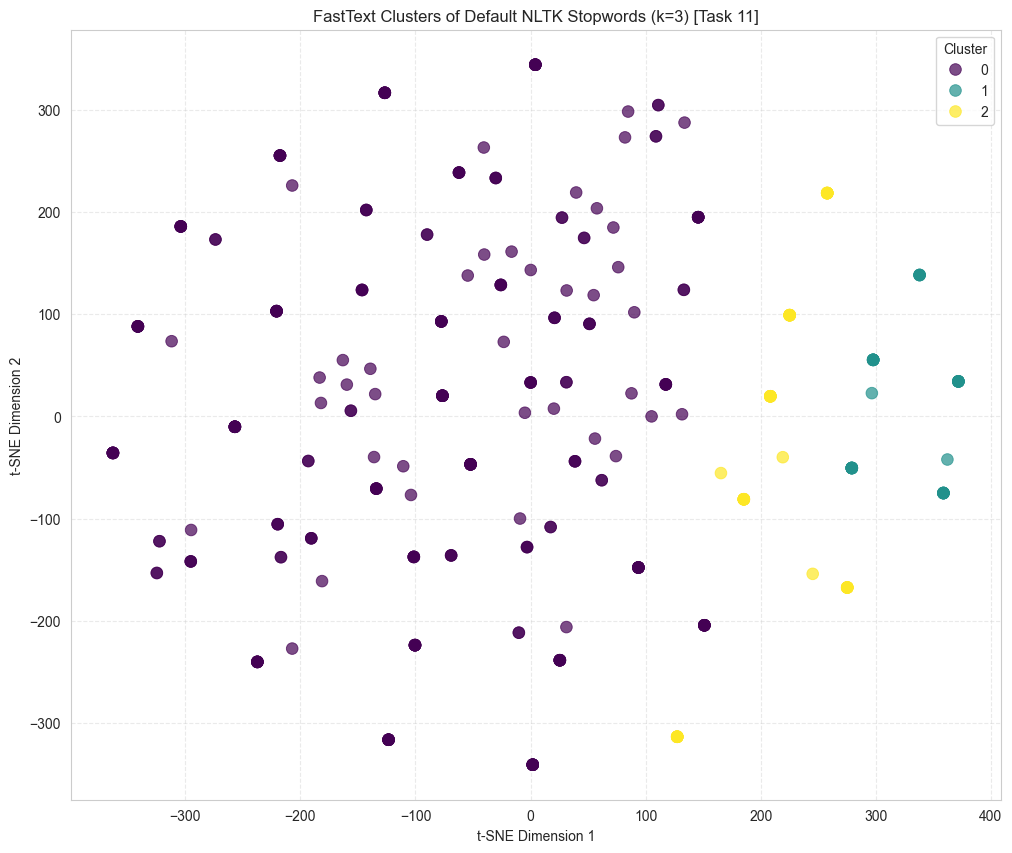

In [41]:

TASK11_DEFAULT_PKL = os.path.join(PKL_FOLDER, 'task11_ft_default.pkl')

if os.path.exists(TASK11_DEFAULT_PKL):
    print(f"Loading cached Task 11 (Default) results from {TASK11_DEFAULT_PKL}...")
    with open(TASK11_DEFAULT_PKL, 'rb') as f:
        cluster_summary_ft_default = pickle.load(f)
        X_tsne_ft_default = pickle.load(f)
    print("Results loaded.")

else:
    print("Cache not found for Task 11 (Default). Running analysis...")

    default_terms = default_stopwords_cluster_df['word'].tolist()

    X_ft_default = []
    valid_terms_ft_default = []

    print("Extracting FastText embeddings for Default stopwords...")
    for term in tqdm(default_terms, desc="Embedding extraction (FastText, Default)"):
        if term in model_ft:
            X_ft_default.append(model_ft[term])
            valid_terms_ft_default.append(term)

    X_ft_default = np.array(X_ft_default)
    print(f"Found embeddings for {len(valid_terms_ft_default)} / {len(default_terms)} words.")
    if len(valid_terms_ft_default) == 0:
        raise ValueError("No embeddings found for Default stopwords.")

    # Cluster on embeddings
    print(f"Running K-Means clustering (k={NUM_CLUSTERS}) on FastText embeddings (Default)...")
    kmeans_ft_default = KMeans(n_clusters=NUM_CLUSTERS, random_state=1, n_init=10)
    clusters_ft_default = kmeans_ft_default.fit_predict(X_ft_default)
    print("Clustering completed.")

    print("Running t-SNE...")
    perplexity_val_default = min(30, len(valid_terms_ft_default) - 1)
    if perplexity_val_default < 1:
        perplexity_val_default = 1

    tsne_ft_default = TSNE(
        n_components=2,
        random_state=1,
        perplexity=perplexity_val_default,
        init='pca'
    )
    X_tsne_ft_default = tsne_ft_default.fit_transform(X_ft_default)
    print("t-SNE completed.")

    cluster_summary_ft_default = pd.DataFrame({
        "word": valid_terms_ft_default,
        "tsne_1": X_tsne_ft_default[:, 0],
        "tsne_2": X_tsne_ft_default[:, 1],
        "cluster": clusters_ft_default
    })


    print(f"Saving Task 11 (Default) results to {TASK11_DEFAULT_PKL}...")
    with open(TASK11_DEFAULT_PKL, 'wb') as f:
        pickle.dump(cluster_summary_ft_default, f)
        pickle.dump(X_tsne_ft_default, f)
    print("Results saved.")

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=cluster_summary_ft_default,
    x='tsne_1',
    y='tsne_2',
    hue='cluster',
    palette='viridis',
    s=70, alpha=0.7, edgecolor=None
)


plt.title(f"FastText Clusters of Default NLTK Stopwords (k={NUM_CLUSTERS}) [Task 11]")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster")
plt.grid(True, linestyle='--', alpha=0.4)
plt.savefig(os.path.join('plot','task11_fastText_default.png'), dpi=300, bbox_inches='tight')
plt.show()


In [42]:
cluster_ids_t11_ft_def = sorted(cluster_summary_ft_default['cluster'].unique())
for cluster_id in cluster_summary_ft_default['cluster'].unique():
        print(f"\nCluster {cluster_id}:")
        # Filter the DataFrame for the current cluster
        subset_df_t11_ft_def = cluster_summary_ft_default[cluster_summary_ft_default['cluster'] == cluster_id].head(15).copy()



        # Drop duplicates by word before translating/printing
        subset_df_t11_ft_def = subset_df_t11_ft_def.drop_duplicates(subset=['word'])


        subset_df_t11_ft_def['Translation'] = translate_words(subset_df_t11_ft_def['word'].tolist())
        # Display table including translation
        print(subset_df_t11_ft_def[['word', 'Translation', 'cluster']].to_markdown(index=False))


Cluster 0:
| word   | Translation   |   cluster |
|:-------|:--------------|----------:|
| biết   | know          |         0 |
| cho    | give          |         0 |
| các    | the           |         0 |
| còn    | still         |         0 |
| cũng   | also          |         0 |
| của    | belong to     |         0 |
| hơn    | than          |         0 |
| khi    | When          |         0 |
| không  | Are not       |         0 |
| làm    | do            |         0 |
| lại    | again         |         0 |
| một    | one           |         0 |
| ngày   | day           |         0 |
| người  | People        |         0 |
| nhiều  | much          |         0 |

Cluster 2:
| word   | Translation   |   cluster |
|:-------|:--------------|----------:|
| có     | Have          |         2 |
| là     | To be         |         2 |
| ra     | go out        |         2 |
| từ     | from          |         2 |
| về     | about         |         2 |
| đó     | there         |         2 |
|

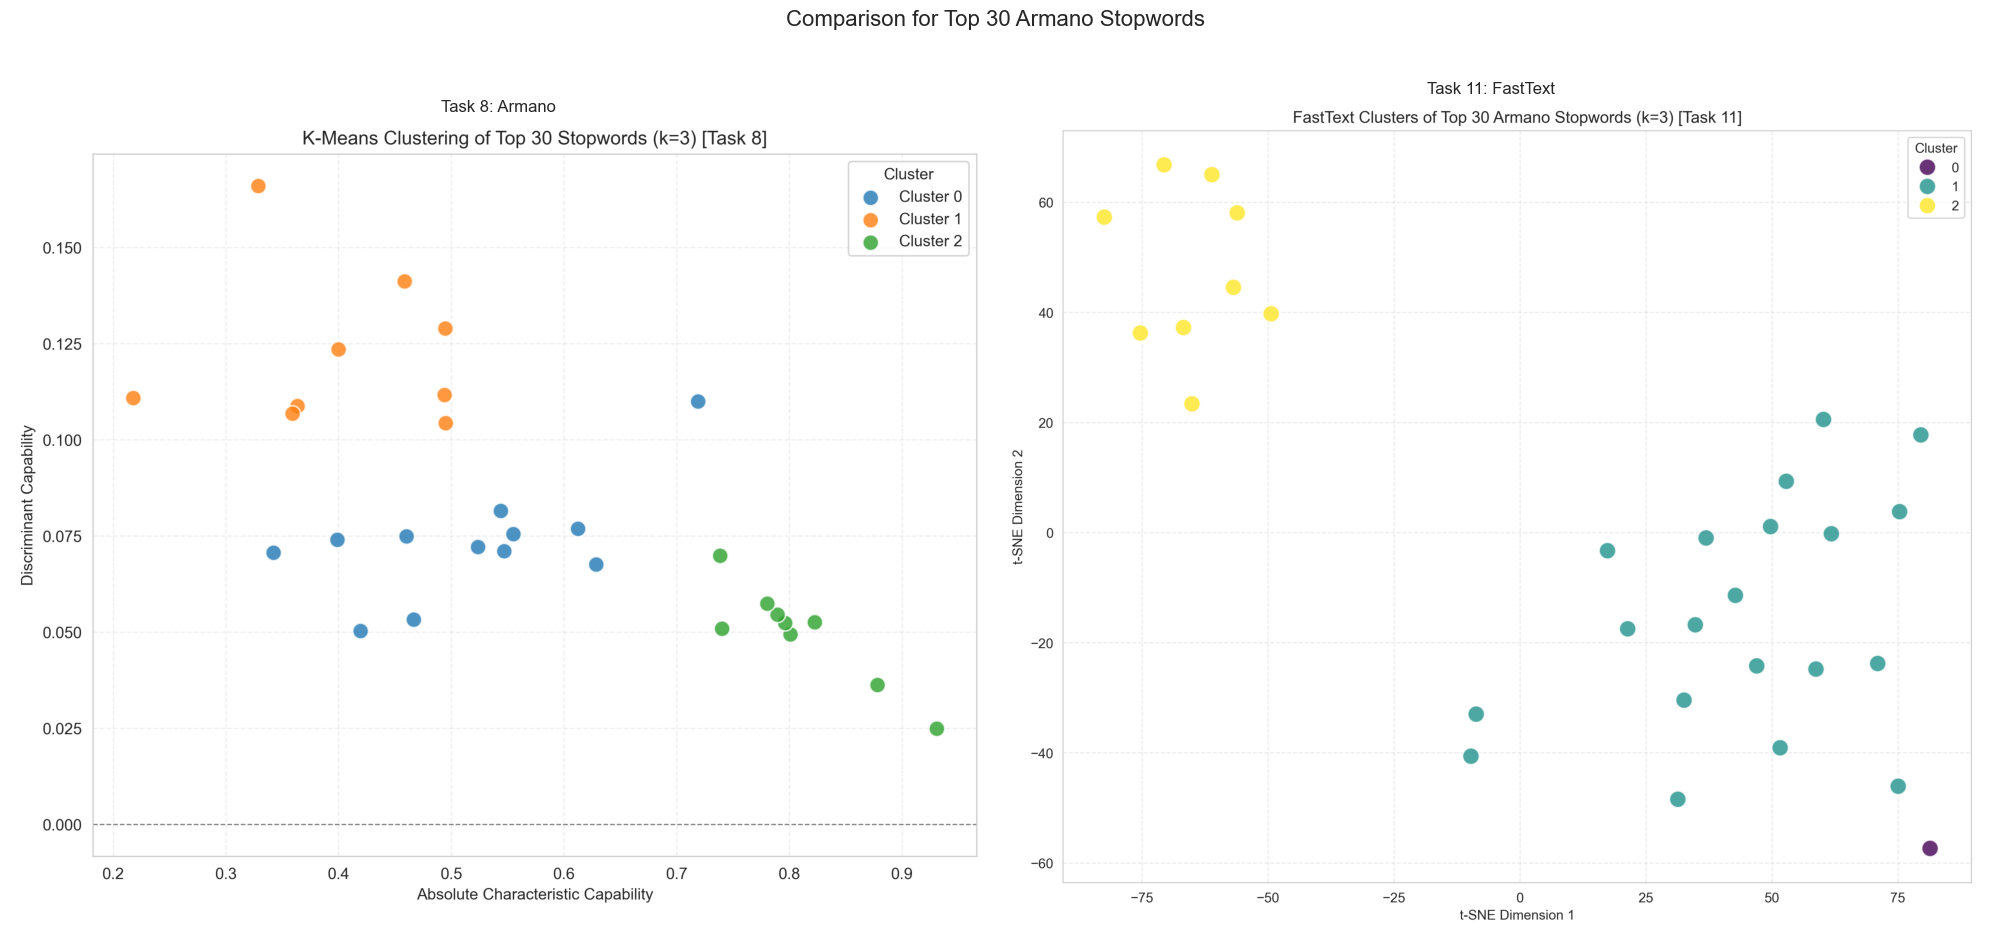

In [43]:



# Comparison for Top 30 Armano Stopwords 


task8_img_path = 'plot/task8.png'
task11_top30_img_path = 'plot/task11_fastText_top30.png'

task9_img_path = 'plot/task9.png'
task11_default_img_path = os.path.join('plot/task11_fastText_default.png')

fig1, axes1 = plt.subplots(1, 2, figsize=(20, 10))
img8 = mpimg.imread(task8_img_path)
axes1[0].imshow(img8)
axes1[0].set_title('Task 8: Armano')
axes1[0].axis('off') 
img11_top30 = mpimg.imread(task11_top30_img_path)
axes1[1].imshow(img11_top30)
axes1[1].set_title('Task 11: FastText')
axes1[1].axis('off')

fig1.suptitle('Comparison for Top 30 Armano Stopwords', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()




In [44]:
print("Creating merged DataFrame with cluster assignments...")


task8_clusters_to_merge = top30_cluster_df[['word', 'cluster']].rename(
    columns={'cluster': 'cluster_task8'}
)
task11_clusters_to_merge = cluster_summary_ft_top30[['word', 'cluster']].rename(
    columns={'cluster': 'cluster_task11'}
)

# Use outer merge in case some words were missing embeddings in Task 11
merged_clusters = pd.merge(
    task8_clusters_to_merge,
    task11_clusters_to_merge,
    on='word',
    how='outer' # Keep all words from both analyses
)

merged_clusters['Translation'] = translate_words(merged_clusters['word'].tolist())
display_cols = ['word', 'Translation', 'cluster_task8', 'cluster_task11']

print("\n==== Merged Cluster Assignments (Task 8 vs Task 11) ====")
print("      (Top 30 Armano Stopwords)")
print(merged_clusters[display_cols].sort_values(by=['cluster_task8', 'cluster_task11']).to_markdown(index=False, floatfmt=".0f"))


Creating merged DataFrame with cluster assignments...

==== Merged Cluster Assignments (Task 8 vs Task 11) ====
      (Top 30 Armano Stopwords)
| word   | Translation   |   cluster_task8 |   cluster_task11 |
|:-------|:--------------|----------------:|-----------------:|
| từ     | from          |               0 |                0 |
| các    | the           |               0 |                1 |
| khi    | When          |               0 |                1 |
| không  | Are not       |               0 |                1 |
| này    | This          |               0 |                1 |
| sau    | after         |               0 |                1 |
| trên   | above         |               0 |                1 |
| vào    | enter         |               0 |                1 |
| ra     | go out        |               0 |                2 |
| về     | about         |               0 |                2 |
| đó     | there         |               0 |                2 |
| để     | to           

## Findings FastText top 30

**Strong Divergence:** Similar to the Word2Vec comparison, the cluster assignments between Task 8 (statistical) and Task 11 (FastText semantic) show significant differences. Words grouped by φ/δ scores are frequently separated when grouped by FastText similarity, and vice-versa.
   
1.  **Task 8 Clusters (Left Plot):** 
    * Same as before
   
2.  **Task 11 Clusters (Right Plot):**
    - **Cluster 1**: A very large, general-purpose cluster containing most of the prepositions, determiners, and common function words (e.g., `của, trong, các, không, người, một`).

    - **Cluster 2**: A smaller cluster grouping core grammatical/auxiliary words like `và (and), có (have), là (to be), đã (past tense),` and `sẽ (will).`

    - **Cluster 0**: An "outlier" cluster containing only `từ (from)`, which FastText/t-SNE identified as semantically distinct from the others in this group.
  
**Interpretation:**

FastText, like Word2Vec, groups many common function words together (mostly in Cluster 0), suggesting it captures their similar contextual usage. However, the specific cluster assignments differ slightly from Word2Vec (comparing Task 11's table to Task 10's table), indicating subtle differences in how the embedding models represent these words' semantics.
  
This comparison **confirms** the finding from Word2Vec: Statistical behavior in a specific corpus (Task 8) is not the same as general semantic function (Task 11).

FastText groups words by their learned linguistic roles (`và, là` are functionally similar, while `của, trong` are also similar), whereas Task 8 grouped them purely by their spread (φ) and distinctiveness (|δ|) across our 8 news categories.

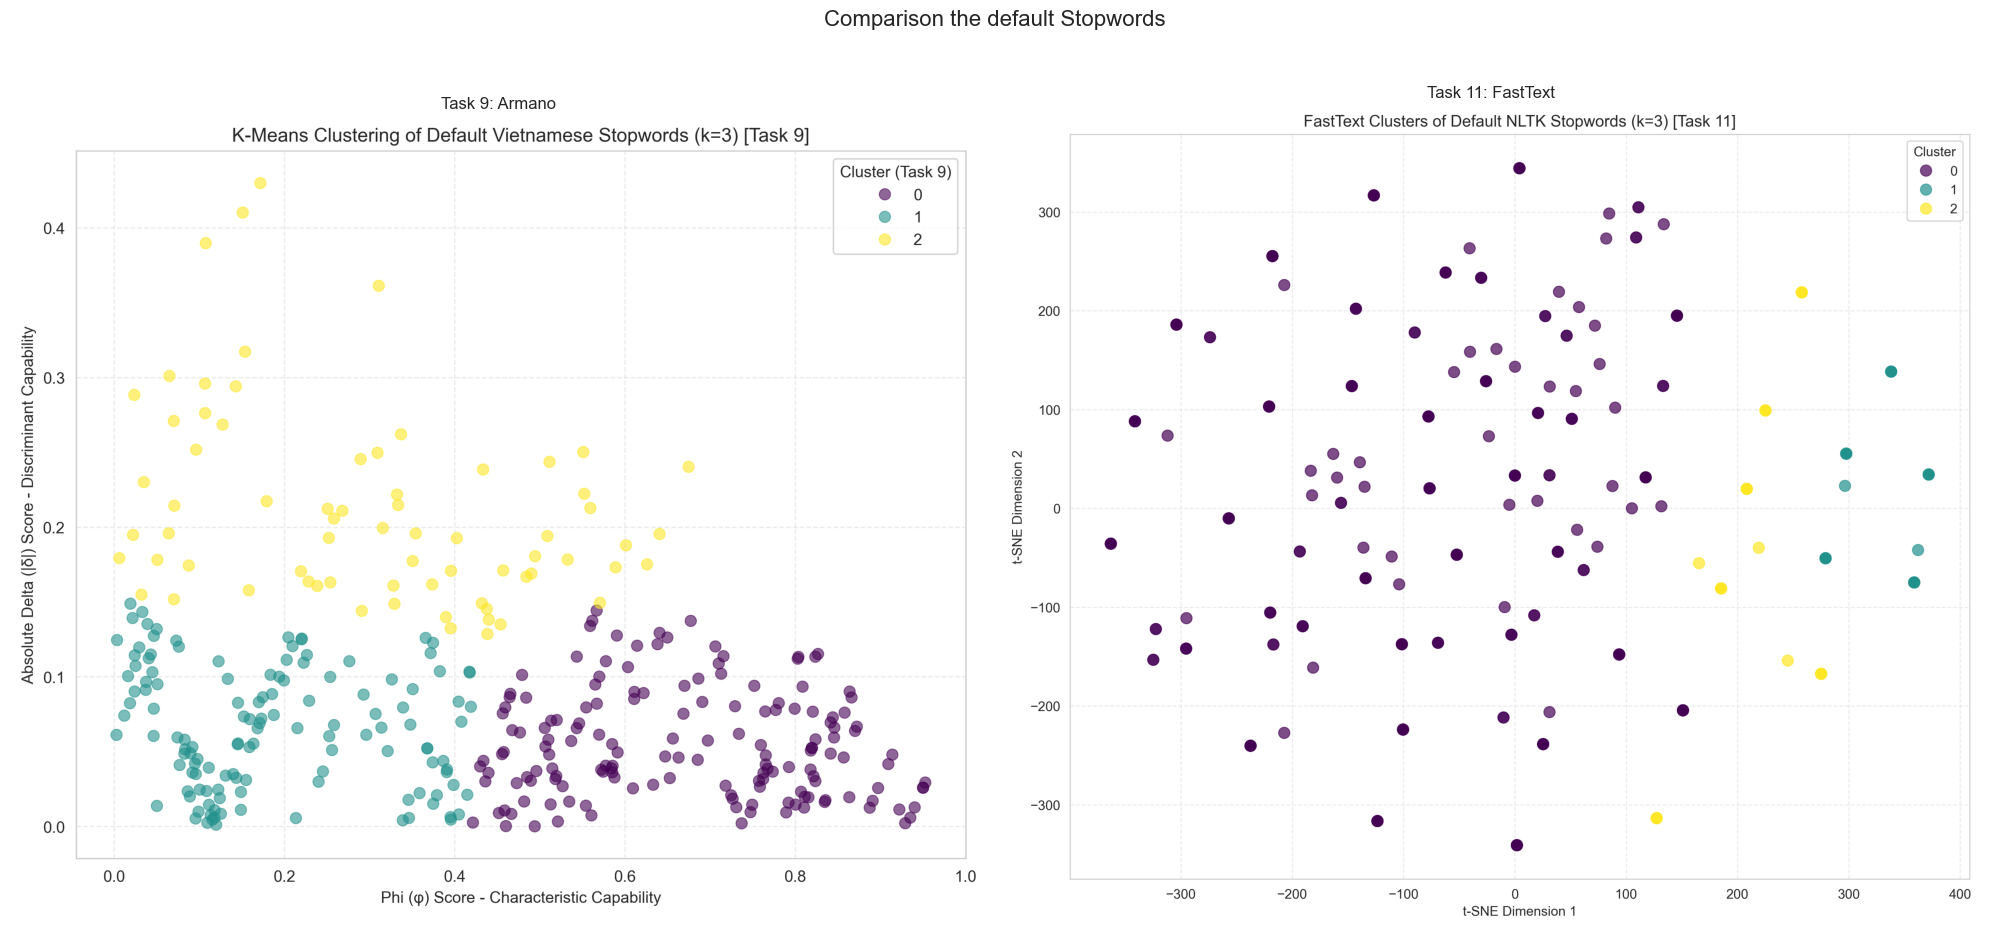

In [45]:
fig1, axes1 = plt.subplots(1, 2, figsize=(20, 10))
img9 = mpimg.imread(task9_img_path)
axes1[0].imshow(img9)
axes1[0].set_title('Task 9: Armano')
axes1[0].axis('off') 
img11_default = mpimg.imread(task11_default_img_path)
axes1[1].imshow(img11_default)
axes1[1].set_title('Task 11: FastText')
axes1[1].axis('off')

fig1.suptitle('Comparison the default Stopwords', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [46]:
print("Merging Task 9 and Task 11 cluster assignments for common words...")


task9_data_full = default_stopwords_cluster_df[['word', 'cluster']].rename(
    columns={'cluster': 'cluster_task9'}
)
task11_data_full = cluster_summary_default[['word', 'cluster']].rename(
    columns={'cluster': 'cluster_task11'}
)

# use "inner" because there are a lot 
merged_common_words = pd.merge(
    task9_data_full,
    task11_data_full,
    on='word',
    how='inner' # Keep only words that appear in both dataframes
)

# Check if enough common words exist 
num_common = len(merged_common_words)
sample_size = min(30, num_common) # Take 30 or fewer if less than 30 common words

if num_common < 30:
    print(f"Warning: Only {num_common} words were found in both Task 9 and Task 11 results. Sampling {num_common} words.")
else:
    print(f"Found {num_common} common words. Sampling 30...")


merged_clusters_sample = merged_common_words.sample(n=sample_size, random_state=23) # Use sample_size


print("Adding translations...")
merged_clusters_sample['Translation'] = translate_words(merged_clusters_sample['word'].tolist())
display_cols = ['word', 'Translation', 'cluster_task9', 'cluster_task11']




print(f"\n--- Random Sample of {sample_size} Common Words: Cluster Assignments (Task 9 vs Task 11) ---")
# Sort for potentially clearer viewing
print(merged_clusters_sample[display_cols].sort_values(by=['cluster_task9', 'cluster_task11']).to_markdown(index=False, floatfmt=".0f"))

Merging Task 9 and Task 11 cluster assignments for common words...
Found 2647 common words. Sampling 30...
Adding translations...

--- Random Sample of 30 Common Words: Cluster Assignments (Task 9 vs Task 11) ---
| word   | Translation   |   cluster_task9 |   cluster_task11 |
|:-------|:--------------|----------------:|-----------------:|
| đã     | Satisfied     |               0 |                0 |
| đó     | there         |               0 |                0 |
| vào    | enter         |               0 |                0 |
| được   | Okay          |               0 |                1 |
| là     | To be         |               0 |                1 |
| các    | the           |               0 |                1 |
| và     | and           |               0 |                1 |
| trong  | in            |               0 |                1 |
| là     | To be         |               0 |                1 |
| trong  | in            |               0 |                1 |
| này    | This    

## Findings FastText default list

**Different Cluster Structures:** The plots clearly show that clustering based on statistical distribution (Task 9, left plot) yields different groupings than clustering based on semantic similarity using FastText (Task 11, right plot). The visual separation and composition of clusters are distinct.
   
1.  **Task 9 Clusters (Left plot)**
    * Same as above
  
2.  **Task 11 Clusters (FastText/t-SNE):**
    - **Cluster 0**: This is a large "mega-cluster" that groups many common function words and high-frequency content words from the stopword list (e.g., `biết - know, của - of, không - not, một - one, người - people`).

    - **Cluster 1**: This cluster appears to group words related to sentence structure and modality, such as `sẽ (will), và (and), đã (past tense), - and bị (passive marker)`.

    - **Cluster 2**: This cluster contains another set of core function words, prepositions, and pronouns, such as `có (have), là (to be), từ (from), về (about), and đó (that)`.
    

**Interpretation:**

This comparison **confirms** our main thesis. Statistical clustering (Task 9) reveals a word's behavior relative to the 8 news topics. Semantic clustering (Task 11) reveals its general linguistic role. The two methods are fundamentally different and do not align.

Loading cached Task 11 (PhoBERT Top 30) results from pkl_folder\task11_phobert_top30.pkl...
Results loaded.


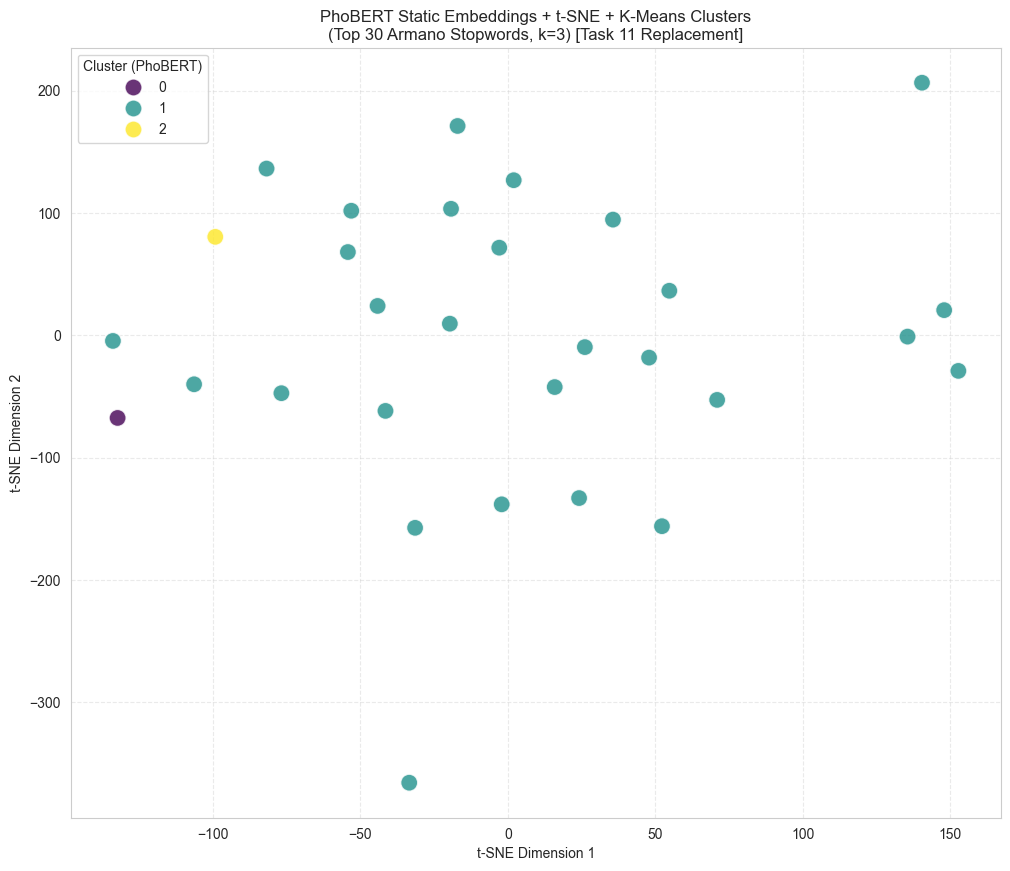

In [47]:

TASK11_PHOBERT_TOP30_PKL = os.path.join(PKL_FOLDER, 'task11_phobert_top30.pkl') 
NUM_CLUSTERS = 3 # Keep consistent


if os.path.exists(TASK11_PHOBERT_TOP30_PKL):
    print(f"Loading cached Task 11 (PhoBERT Top 30) results from {TASK11_PHOBERT_TOP30_PKL}...")
    with open(TASK11_PHOBERT_TOP30_PKL, 'rb') as f:
        cluster_summary_phobert_top30 = pickle.load(f)
        X_tsne_phobert_top30 = pickle.load(f)
    print("Results loaded.")

else:
    print("Cache not found for Task 11 (PhoBERT Top 30). Running analysis...")


    top_terms = top30_cluster_df['word'].tolist()

    X_phobert_top30 = []
    valid_terms_phobert_top30 = []

    print("Extracting PhoBERT static embeddings for Top 30 Armano stopwords...")
    with torch.no_grad(): # Disable gradient calculations for efficiency
        for term in tqdm(top_terms, desc="Embedding extraction (PhoBERT, Top 30)"):

            if term in phobert_vocab:
                token_id = phobert_vocab[term]
                # Get the static embedding vector
                embedding_vector = phobert_embeddings.weight[token_id].cpu().numpy()
                X_phobert_top30.append(embedding_vector)
                valid_terms_phobert_top30.append(term)

                
    X_phobert_top30 = np.array(X_phobert_top30)
    print(f"Found static embeddings for {len(valid_terms_phobert_top30)} / {len(top_terms)} words.")
    if len(valid_terms_phobert_top30) == 0:
        raise ValueError("No PhoBERT embeddings found for Top 30 stopwords (as single tokens).")

    # Cluster on embeddings
    print(f"Running K-Means clustering (k={NUM_CLUSTERS}) on PhoBERT embeddings...")
    kmeans_phobert_top30 = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10) # Changed random state slightly
    # Cluster directly on PhoBERT embeddings (t-SNE is just for visualization)
    clusters_phobert_top30 = kmeans_phobert_top30.fit_predict(X_phobert_top30) 
    print("Clustering completed.")

    print("Running t-SNE for visualization...")
    # Adjust perplexity based on the number of valid terms found
    perplexity_val = min(5, len(valid_terms_phobert_top30) - 1)
    if perplexity_val < 1: perplexity_val = 1

    tsne_phobert_top30 = TSNE(
        n_components=2,
        random_state=2, # Keep consistent random state for t-SNE
        perplexity=perplexity_val,
        init='pca',
    )
    # Fit t-SNE on the original PhoBERT embeddings
    X_tsne_phobert_top30 = tsne_phobert_top30.fit_transform(X_phobert_top30) 
    print("t-SNE completed.")

    # Create summary DataFrame including t-SNE coordinates and clusters
    cluster_summary_phobert_top30 = pd.DataFrame({
        "word": valid_terms_phobert_top30,
        "tsne_1": X_tsne_phobert_top30[:, 0],
        "tsne_2": X_tsne_phobert_top30[:, 1],
        "cluster": clusters_phobert_top30 # Store the clusters found using original embeddings
    })

    print(f"Saving Task 11 (PhoBERT Top 30) results to {TASK11_PHOBERT_TOP30_PKL}...")
    with open(TASK11_PHOBERT_TOP30_PKL, 'wb') as f:
        pickle.dump(cluster_summary_phobert_top30, f)
        pickle.dump(X_tsne_phobert_top30, f) # Save t-SNE coords if needed later
    print("Results saved.")


plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=cluster_summary_phobert_top30,
    x='tsne_1',
    y='tsne_2',
    hue='cluster', # Color by the cluster found on original embeddings
    palette='viridis', # Or another palette
    s=150, alpha=0.8, edgecolor='w'
)


plt.title(f"PhoBERT Static Embeddings + t-SNE + K-Means Clusters\n(Top 30 Armano Stopwords, k={NUM_CLUSTERS}) [Task 11 Replacement]")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster (PhoBERT)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.savefig(os.path.join('plot','task11_phobert_top30.png'), dpi=300, bbox_inches='tight') # Optional save
plt.show()



In [48]:
cluster_ids_t11_p1 = sorted(cluster_summary_phobert_top30['cluster'].unique())
for cluster_id in cluster_ids_t11_p1:
        print(f"\nCluster {cluster_id}:")
        # Filter the DataFrame for the current cluster

        subset_df_t11 = cluster_summary_phobert_top30[cluster_summary_phobert_top30['cluster'] == cluster_id].copy()    
        # Drop duplicates by word before translating/printing

        subset_df_t11 = subset_df_t11.drop_duplicates(subset=['word'])  
        subset_df_t11['Translation'] = translate_words(subset_df_t11['word'].tolist())
        
        # Display table including translation
        print(subset_df_t11[['word', 'Translation', 'cluster']].to_markdown(index=False))



             


Cluster 0:
| word   | Translation   |   cluster |
|:-------|:--------------|----------:|
| là     | To be         |         0 |

Cluster 1:
| word   | Translation   |   cluster |
|:-------|:--------------|----------:|
| và     | and           |         1 |
| của    | belong to     |         1 |
| trong  | in            |         1 |
| được   | Okay          |         1 |
| có     | Have          |         1 |
| với    | with          |         1 |
| đã     | Satisfied     |         1 |
| các    | the           |         1 |
| để     | to            |         1 |
| khi    | When          |         1 |
| không  | Are not       |         1 |
| đó     | there         |         1 |
| này    | This          |         1 |
| về     | about         |         1 |
| vào    | enter         |         1 |
| người  | People        |         1 |
| từ     | from          |         1 |
| theo   | according to  |         1 |
| ra     | go out        |         1 |
| một    | one           |         1 |
|

Loading cached Task 11 (PhoBERT Top 30) results from pkl_folder\task11_phobert_default.pkl...
Results loaded.


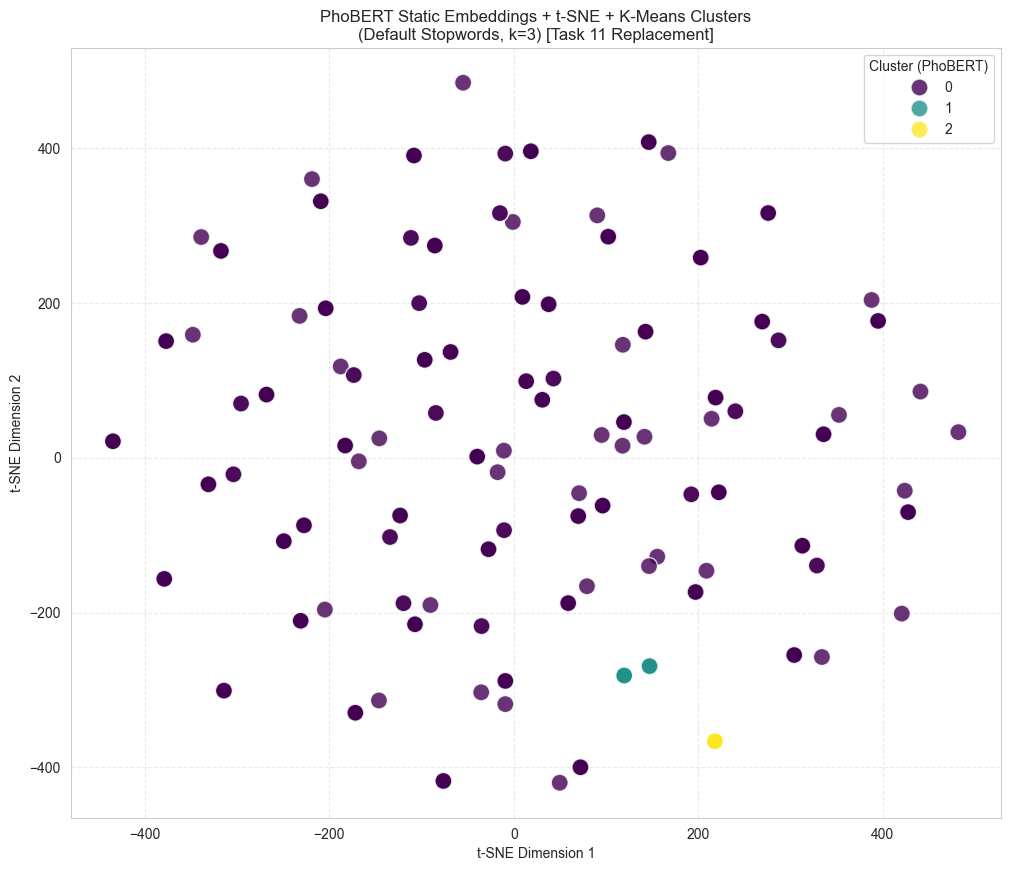

In [49]:

TASK11_PHOBERT_DEFAULT = os.path.join(PKL_FOLDER, 'task11_phobert_default.pkl') 
NUM_CLUSTERS = 3 


if os.path.exists(TASK11_PHOBERT_DEFAULT):
    print(f"Loading cached Task 11 (PhoBERT Top 30) results from {TASK11_PHOBERT_DEFAULT}...")
    with open(TASK11_PHOBERT_DEFAULT, 'rb') as f:
        cluster_summary_phobert_default = pickle.load(f)
        X_tsne_phobert_default = pickle.load(f)
    print("Results loaded.")

else:
    print("Cache not found for Task 11 (PhoBERT Top 30). Running analysis...")


    top_terms = default_stopwords_cluster_df['word'].tolist()

    X_phobert_default = []
    valid_terms_phobert_default = []

    print("Extracting PhoBERT static embeddings for Top 30 Armano stopwords...")
    with torch.no_grad(): # Disable gradient calculations for efficiency
        for term in tqdm(top_terms, desc="Embedding extraction (PhoBERT, Top 30)"):

            if term in phobert_vocab:
                token_id = phobert_vocab[term]
                # Get the static embedding vector
                embedding_vector = phobert_embeddings.weight[token_id].cpu().numpy()
                X_phobert_default.append(embedding_vector)
                valid_terms_phobert_default.append(term)

                
    X_phobert_default = np.array(X_phobert_default)
    print(f"Found static embeddings for {len(valid_terms_phobert_default)} / {len(top_terms)} words.")
    if len(valid_terms_phobert_default) == 0:
        raise ValueError("No PhoBERT embeddings found for Top 30 stopwords (as single tokens).")

    # Cluster on embeddings
    print(f"Running K-Means clustering (k={NUM_CLUSTERS}) on PhoBERT embeddings...")
    kmeans_phobert_default = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10) # Changed random state slightly
    # Cluster directly on PhoBERT embeddings (t-SNE is just for visualization)
    cluster_summary_phobert_default = kmeans_phobert_default.fit_predict(X_phobert_default) 
    print("Clustering completed.")

    print("Running t-SNE for visualization...")
    # Adjust perplexity based on the number of valid terms found
    perplexity_val = min(5, len(valid_terms_phobert_default) - 1)
    if perplexity_val < 1: perplexity_val = 1

    tsne_phobert_default = TSNE(
        n_components=2,
        random_state=2, # Keep consistent random state for t-SNE
        perplexity=perplexity_val,
        init='pca',
    )
    # Fit t-SNE on the original PhoBERT embeddings
    X_tsne_phobert_default = tsne_phobert_default.fit_transform(X_phobert_default) 
    print("t-SNE completed.")

    # Create summary DataFrame including t-SNE coordinates and clusters
    cluster_summary_phobert_default = pd.DataFrame({
        "word": valid_terms_phobert_default,
        "tsne_1": X_tsne_phobert_default[:, 0],
        "tsne_2": X_tsne_phobert_default[:, 1],
        "cluster": cluster_summary_phobert_default # Store the clusters found using original embeddings
    })

    print(f"Saving Task 11 (PhoBERT Top 30) results to {TASK11_PHOBERT_DEFAULT}...")
    with open(TASK11_PHOBERT_DEFAULT, 'wb') as f:
        pickle.dump(cluster_summary_phobert_default, f)
        pickle.dump(X_tsne_phobert_default, f) # Save t-SNE coords if needed later
    print("Results saved.")

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=cluster_summary_phobert_default,
    x='tsne_1',
    y='tsne_2',
    hue='cluster', # Color by the cluster found on original embeddings
    palette='viridis', # Or another palette
    s=150, alpha=0.8, edgecolor='w'
)


plt.title(f"PhoBERT Static Embeddings + t-SNE + K-Means Clusters\n(Default Stopwords, k={NUM_CLUSTERS}) [Task 11 Replacement]")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster (PhoBERT)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.savefig(os.path.join('plot','task11_phobert_default.png'), dpi=300, bbox_inches='tight') # Optional save
plt.show()



In [50]:
cluster_ids_t11_p2 = sorted(cluster_summary_phobert_default['cluster'].unique())
for cluster_id in cluster_ids_t11_p2:
    print(f"\nCluster {cluster_id}:")
    
    subset_df_t11 = (
        cluster_summary_phobert_default[
            cluster_summary_phobert_default['cluster'] == cluster_id
        ]
        .copy()
    )


    # Drop duplicates by word before translating/printing
    subset_df_t11 = subset_df_t11.drop_duplicates(subset=['word'])


    subset_df_t11['Translation'] = translate_words(subset_df_t11['word'].tolist())
    print(subset_df_t11[['word', 'Translation', 'cluster']].to_markdown(index=False))




Cluster 0:
| word   | Translation   |   cluster |
|:-------|:--------------|----------:|
| biết   | know          |         0 |
| các    | the           |         0 |
| còn    | still         |         0 |
| có     | Have          |         0 |
| cũng   | also          |         0 |
| của    | belong to     |         0 |
| hơn    | than          |         0 |
| khi    | When          |         0 |
| không  | Are not       |         0 |
| là     | To be         |         0 |
| làm    | do            |         0 |
| lại    | again         |         0 |
| một    | one           |         0 |
| ngày   | day           |         0 |
| người  | People        |         0 |
| nhiều  | much          |         0 |
| như    | like          |         0 |
| những  | these         |         0 |
| này    | This          |         0 |
| năm    | year          |         0 |
| phải   | Right         |         0 |
| ra     | go out        |         0 |
| sau    | after         |         0 |
| sẽ     | wi

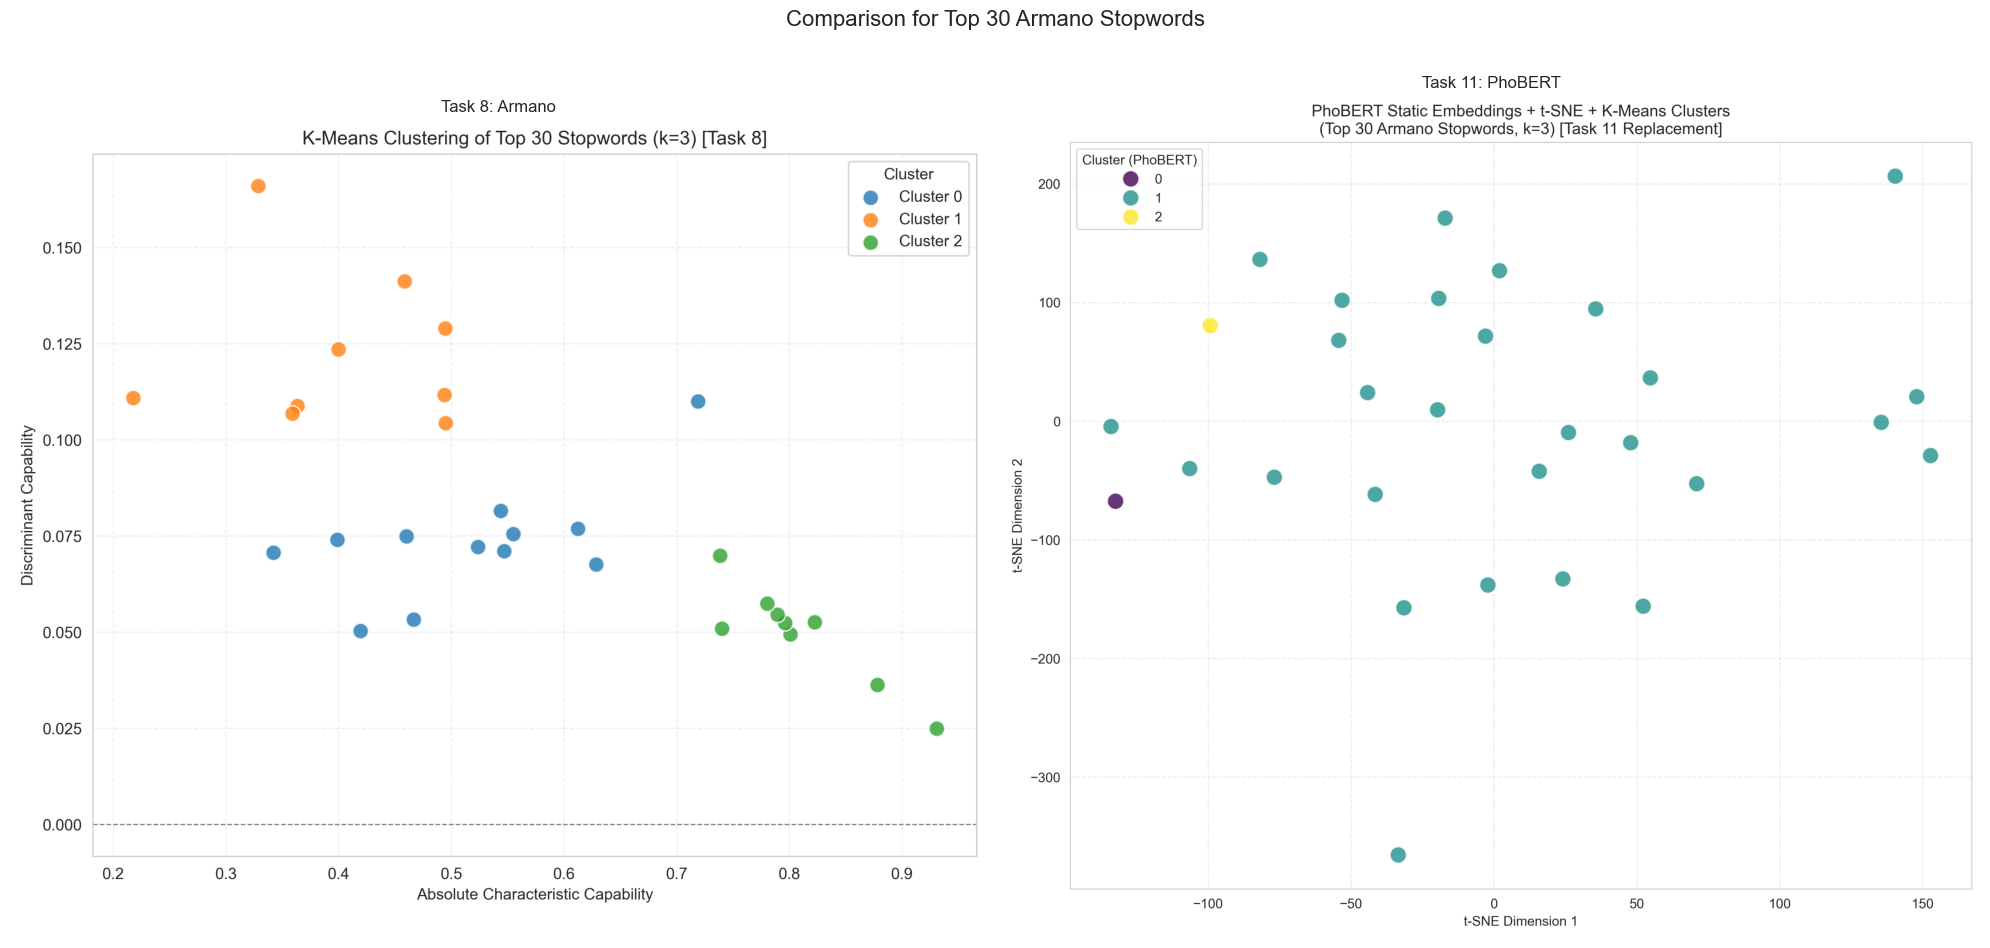

In [51]:


# Comparison for Top 30 Armano Stopwords 

task8_img_path = 'plot/task8.png'
task11_top30_img_path = 'plot/task11_phobert_top30.png'

task9_img_path = 'plot/task9.png'
task11_default_img_path = os.path.join('plot/task11_phobert_default.png')

fig1, axes1 = plt.subplots(1, 2, figsize=(20, 10))
img8 = mpimg.imread(task8_img_path)
axes1[0].imshow(img8)
axes1[0].set_title('Task 8: Armano')
axes1[0].axis('off') 
img11_top30 = mpimg.imread(task11_top30_img_path)
axes1[1].imshow(img11_top30)
axes1[1].set_title('Task 11: PhoBERT')
axes1[1].axis('off')

fig1.suptitle('Comparison for Top 30 Armano Stopwords', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()




In [52]:
print("Creating merged DataFrame with cluster assignments...")


task8_clusters_to_merge = top30_cluster_df[['word', 'cluster']].rename(
    columns={'cluster': 'cluster_task8'}
)
task11_clusters_to_merge = cluster_summary_phobert_top30[['word', 'cluster']].rename(
    columns={'cluster': 'cluster_task11'}
)

# Use outer merge in case some words were missing embeddings in Task 11
merged_clusters = pd.merge(
    task8_clusters_to_merge,
    task11_clusters_to_merge,
    on='word',
    how='outer' # Keep all words from both analyses
)

merged_clusters['Translation'] = translate_words(merged_clusters['word'].tolist())
display_cols = ['word', 'Translation', 'cluster_task8', 'cluster_task11']

print("\n==== Merged Cluster Assignments (Task 8 vs Task 11) ====")
print("      (Top 30 Armano Stopwords)")
print(merged_clusters[display_cols].sort_values(by=['cluster_task8', 'cluster_task11']).to_markdown(index=False, floatfmt=".0f"))


Creating merged DataFrame with cluster assignments...

==== Merged Cluster Assignments (Task 8 vs Task 11) ====
      (Top 30 Armano Stopwords)
| word   | Translation   |   cluster_task8 |   cluster_task11 |
|:-------|:--------------|----------------:|-----------------:|
| các    | the           |               0 |                1 |
| khi    | When          |               0 |                1 |
| không  | Are not       |               0 |                1 |
| này    | This          |               0 |                1 |
| ra     | go out        |               0 |                1 |
| sau    | after         |               0 |                1 |
| trên   | above         |               0 |                1 |
| từ     | from          |               0 |                1 |
| vào    | enter         |               0 |                1 |
| về     | about         |               0 |                1 |
| đó     | Error         |               0 |                1 |
| để     | Error        

## Findings PhoBERT top 30 armano

**Strong Divergence:** Similar to the other comparison, the cluster assignments between Task 8 (statistical) and Task 11 (PhoBERT semantic) show significant differences. Words grouped by φ/δ scores are frequently separated when grouped by PhoBERT similarity, and vice-versa.
   
1.  **Task 8 Clusters (Left Plot):** 
    * Same as before
   
2.  **Task 11 Clusters (Right Plot):**
    - **Cluster 1**: Forms a massive "super-cluster" containing 28 of the 30 words. PhoBERT's embeddings, visualized by t-SNE, group almost all these function words together, suggesting they share a similar general semantic space.

    - **Cluster 0 & 2**: These are "singleton" clusters. PhoBERT identifies `là (to be)` and `cho (give)` as semantic outliers, completely distinct from each other and from the 28 other words in the main group.
  
**Conclustion**

This comparison provides the clearest evidence of the difference between the two analysis types.

Task 8 (Statistical) successfully separated the words based on their behavior in our news corpus (e.g., và behaved more like an ideal stopword than người).

Task 11 (Semantic), using the powerful PhoBERT model, essentially concluded that 28 of these words are "general function words" and grouped them together, while identifying là and cho as having unique linguistic roles distinct from all the others.

This proves that a word's corpus-specific statistical profile (φ/δ) and its general semantic/functional meaning (Embedding) are two fundamentally different properties.

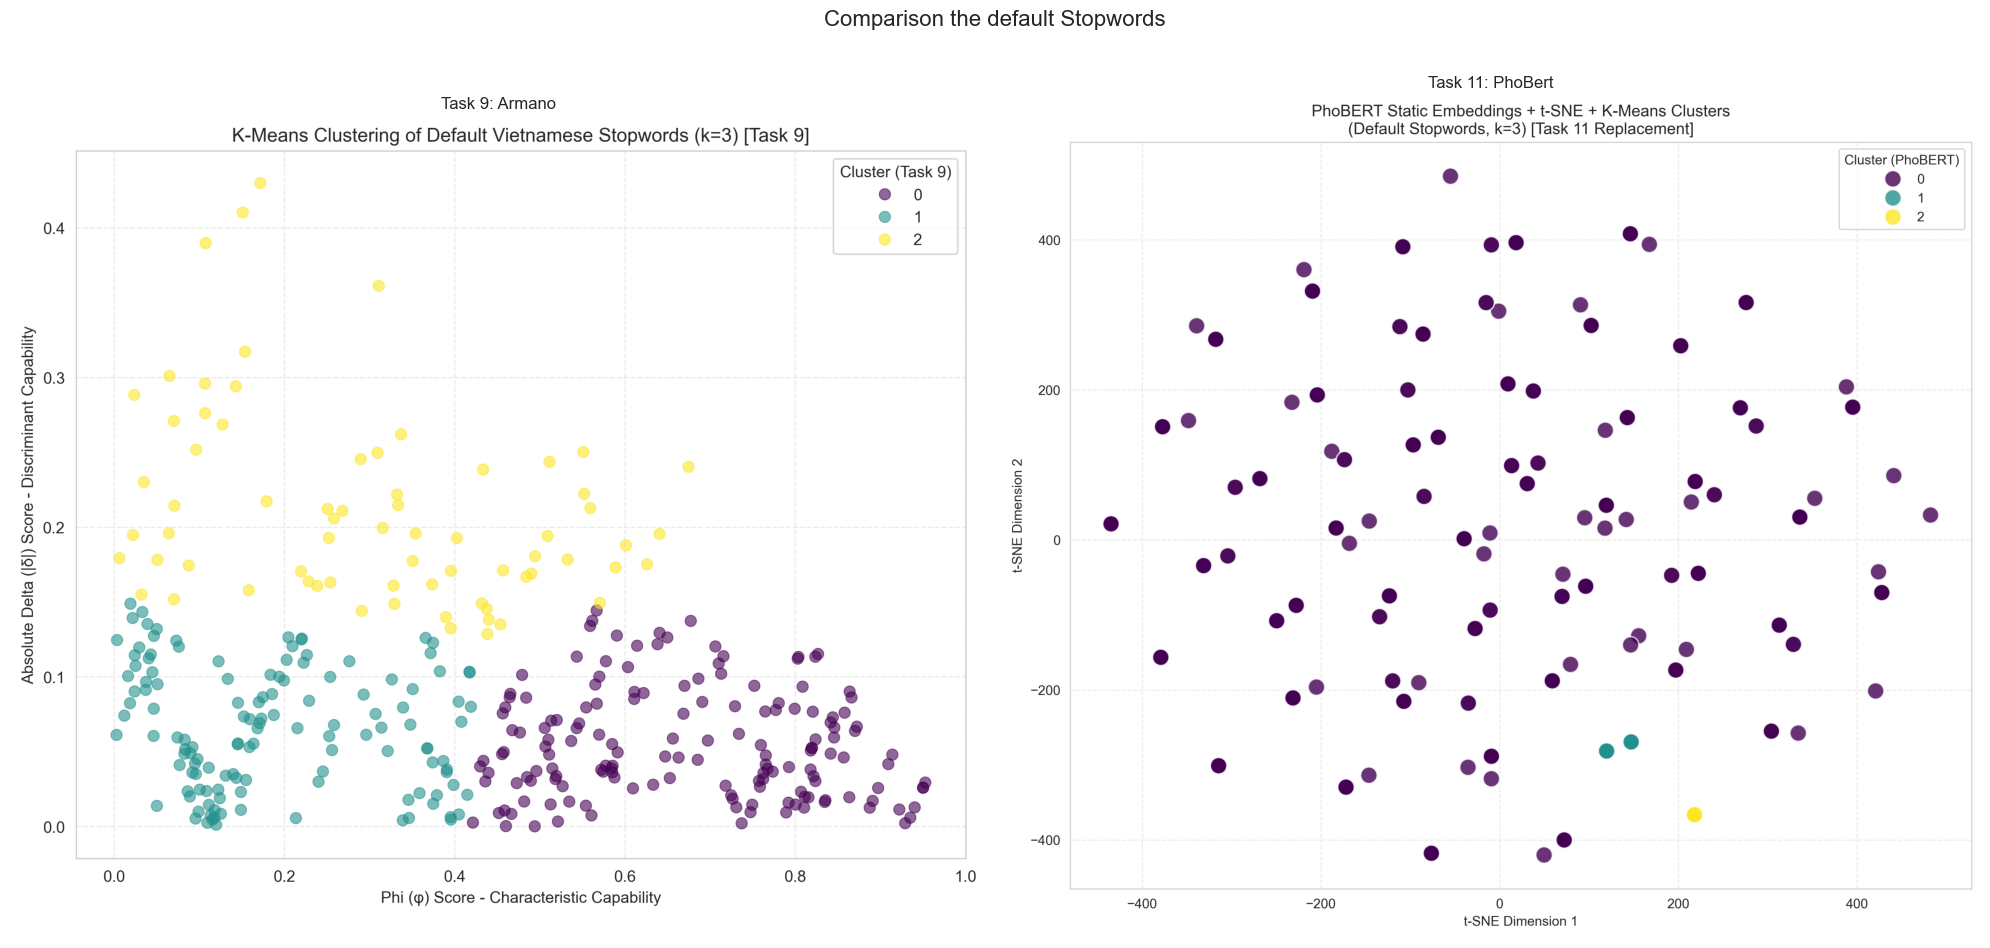

In [53]:
fig1, axes1 = plt.subplots(1, 2, figsize=(20, 10))
img9 = mpimg.imread(task9_img_path)
axes1[0].imshow(img9)
axes1[0].set_title('Task 9: Armano')
axes1[0].axis('off') 
img11_default = mpimg.imread(task11_default_img_path)
axes1[1].imshow(img11_default)
axes1[1].set_title('Task 11: PhoBert')
axes1[1].axis('off')

fig1.suptitle('Comparison the default Stopwords', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [54]:
print("Merging Task 9 and Task 11 cluster assignments for common words...")


task9_data_full = default_stopwords_cluster_df[['word', 'cluster']].rename(
    columns={'cluster': 'cluster_task9'}
)
task11_data_full = cluster_summary_phobert_default[['word', 'cluster']].rename(
    columns={'cluster': 'cluster_task11'}
)

# use "inner" because there are a lot 
merged_common_words = pd.merge(
    task9_data_full,
    task11_data_full,
    on='word',
    how='inner' # Keep only words that appear in both dataframes
)

num_common = len(merged_common_words)
sample_size = min(30, num_common) # Take 30 or fewer if less than 30 common words

if num_common < 30:
    print(f"Warning: Only {num_common} words were found in both Task 9 and Task 11 results. Sampling {num_common} words.")
else:
    print(f"Found {num_common} common words. Sampling 30...")


merged_clusters_sample = merged_common_words.sample(n=sample_size, random_state=23) # Use sample_size


print("Adding translations...")
merged_clusters_sample['Translation'] = translate_words(merged_clusters_sample['word'].tolist())
display_cols = ['word', 'Translation', 'cluster_task9', 'cluster_task11']




print(f"\n--- Random Sample of {sample_size} Common Words: Cluster Assignments (Task 9 vs Task 11) ---")
# Sort for potentially clearer viewing
print(merged_clusters_sample[display_cols].sort_values(by=['cluster_task9', 'cluster_task11']).to_markdown(index=False, floatfmt=".0f"))

Merging Task 9 and Task 11 cluster assignments for common words...
Found 2647 common words. Sampling 30...
Adding translations...

--- Random Sample of 30 Common Words: Cluster Assignments (Task 9 vs Task 11) ---
| word   | Translation   |   cluster_task9 |   cluster_task11 |
|:-------|:--------------|----------------:|-----------------:|
| đã     | Error         |               0 |                0 |
| được   | Error         |               0 |                0 |
| đó     | Error         |               0 |                0 |
| để     | to            |               0 |                0 |
| là     | To be         |               0 |                0 |
| các    | the           |               0 |                0 |
| và     | and           |               0 |                0 |
| vào    | enter         |               0 |                0 |
| trong  | in            |               0 |                0 |
| là     | To be         |               0 |                0 |
| trong  | in      

## Findings PhoBERT default list

**Divergence in Groupings:** As seen with the Armano words, the clustering results differ significantly between the two methods. A word's cluster assignment based on its statistical distribution (Task 9) often does not match its cluster based on semantic similarity (Task 10).

1.  **Task 9 Clusters (φ/δ):**
    - Same as above
  

2.  **Task 10 Clusters (Word2Vec/t-SNE):**
    - **Cluster 0**: This is a massive "super-cluster" that contains almost all (51+ words) of the default stopwords. It groups together a wide range of function words, including `và (and), của (of), không (not), là (to be), một (one), and người (people)`.

    - **Cluster 1 & 2**: These are "singleton" clusters. The K-Means algorithm identified `về (about)` and `cho (give)` as being so semantically unique (in their static vector representation) that each one was assigned to its own individual cluster, separate from all other stopwords.
  
  

**Interpretation:**

This strongly reinforces our main finding. A word's statistical role in a specific corpus (Task 9) is fundamentally different from its general semantic meaning as learned by a large language model like PhoBERT (Task 11). PhoBERT sees most stopwords as one large, similar group, while the φ/δ metrics can find nuanced statistical differences between them based on the corpus.